
===== WILL 5.0 : Parameter-Free Model (Y*=1, λ=1) =====
Galaxies analysed : 163
Median RMSE [km/s]: 24.62



,RMSE
Galaxy,
UGC07690,1.989042
UGC07151,2.459515
UGC07559,2.782431
UGC07125,2.930353
UGC07866,3.385618
UGC07577,3.448166
UGC09992,3.560620
UGC04483,3.752276
NGC4068,4.098127


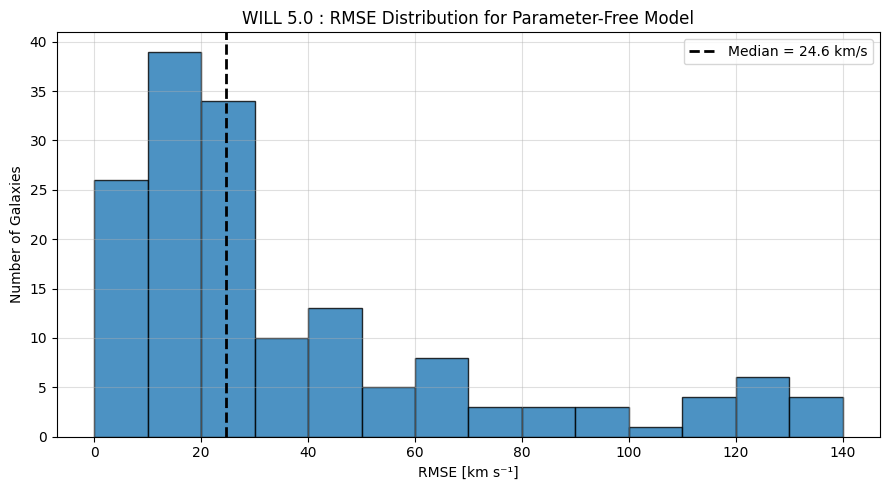

In [ ]:
# ============  WILL 5.0 : Parameter-Free Model (Y*=1, λ=1) ===============
# Проверяем "чистую" модель без свободных параметров.
# Y_star и lambda принудительно установлены в 1.0.
# ========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from IPython.display import display

# ---------- 1. Подготовка данных (без изменений) --------------------
DATA = '/content/DATA'
META_FILE = f'{DATA}/table1.dat'
CURV_FILE = f'{DATA}/table2.dat'

# Загрузка метаданных
meta = pd.read_fwf(
    META_FILE,
    colspecs=[(0,11), (112,115)],
    names=['Galaxy', 'Qual']
)
meta['Qual'] = pd.to_numeric(meta['Qual'], errors='coerce')

# Загрузка кривых вращения
curves = pd.read_table(
    CURV_FILE, sep=r'\s+', comment='#', header=None,
    usecols=[0, 2, 3, 5, 6, 7],
    names=['Galaxy', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
)
num_cols = ['r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r', 'Vobs'], inplace=True)


# ---------- 2. Решатель без параметров -----------------------------------
def will_v_parameter_free(df):
    """
    Рассчитывает скорость по формуле, где Y_star=1 и lambda=1.
    """
    df = df.sort_values('r').copy()

    # Y_star = 1.0
    v_bary_sq = df['Vgas']**2 + (df['Vdisk']**2 + df['Vbul']**2)

    integral = cumulative_trapezoid(v_bary_sq, df['r'], initial=0.0)

    # lambda = 1.0
    geom_term = np.zeros_like(df['r'])
    non_zero_r = df['r'] > 0
    geom_term[non_zero_r] = integral[non_zero_r] / df.loc[non_zero_r, 'r']

    v_pred_sq = v_bary_sq + geom_term
    return np.sqrt(np.clip(v_pred_sq, 0, None))


# ---------- 3. Основной цикл (без оптимизации) ------------------------
results = []
galaxies_to_run = meta[meta['Qual'] <= 2]['Galaxy'].unique()

for galaxy_name in galaxies_to_run:
    gdf = curves[curves['Galaxy'] == galaxy_name]
    if len(gdf) < 3:
        continue

    v_predicted = will_v_parameter_free(gdf)
    rmse = np.sqrt(np.mean((gdf['Vobs'] - v_predicted)**2))

    if np.isfinite(rmse):
        results.append({'Galaxy': galaxy_name, 'RMSE': rmse})

# Создаем итоговый DataFrame
df_results = pd.DataFrame(results).set_index('Galaxy').sort_values('RMSE')


# ---------- 4. Вывод результатов ---------------------------------------
print("\n===== WILL 5.0 : Parameter-Free Model (Y*=1, λ=1) =====")
print(f"Galaxies analysed : {len(df_results)}")
print(f"Median RMSE [km/s]: {df_results.RMSE.median():.2f}\n")
display(df_results.head(20))

plt.figure(figsize=(9, 5))
plt.hist(df_results.RMSE, bins=np.arange(0, 150, 10), edgecolor='k', alpha=0.8)
plt.axvline(df_results.RMSE.median(), ls='--', lw=2, c='k',
            label=f"Median = {df_results.RMSE.median():.1f} km/s")
plt.xlabel('RMSE [km s⁻¹]')
plt.ylabel('Number of Galaxies')
plt.title('WILL 5.0 : RMSE Distribution for Parameter-Free Model')
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


===== WILL: Результаты для 'Локальной' дифференциальной модели =====
Обработано галактик : 159
Общий RMSE (медиана): 46.44 км/с
Хвостовой RMSE (медиана): 60.69 км/с

--- Топ-5 ЛУЧШИХ результатов (по общему RMSE) ---

Galaxy: UGC09992 (RMSE: 4.08, Tail RMSE: 4.08)
Последние 5 точек (r, V_obs, V_pred):
  r= 0.78, Vobs=  28.1, Vpred=  25.7
  r= 1.55, Vobs=  31.3, Vpred=  30.7
  r= 2.34, Vobs=  33.0, Vpred=  31.1
  r= 3.12, Vobs=  33.4, Vpred=  30.5
  r= 3.89, Vobs=  34.3, Vpred=  26.2

Galaxy: UGC07866 (RMSE: 4.17, Tail RMSE: 4.87)
Последние 5 точек (r, V_obs, V_pred):
  r= 1.00, Vobs=  23.9, Vpred=  24.8
  r= 1.33, Vobs=  26.0, Vpred=  23.8
  r= 1.67, Vobs=  28.2, Vpred=  24.2
  r= 2.00, Vobs=  30.6, Vpred=  25.0
  r= 2.32, Vobs=  33.1, Vpred=  25.0

Galaxy: UGC07559 (RMSE: 4.62, Tail RMSE: 3.58)
Последние 5 точек (r, V_obs, V_pred):
  r= 1.08, Vobs=  21.4, Vpred=  23.1
  r= 1.45, Vobs=  26.1, Vpred=  23.6
  r= 1.80, Vobs=  29.7, Vpred=  23.9
  r= 2.17, Vobs=  31.1, Vpred=  26.8
  r= 2.

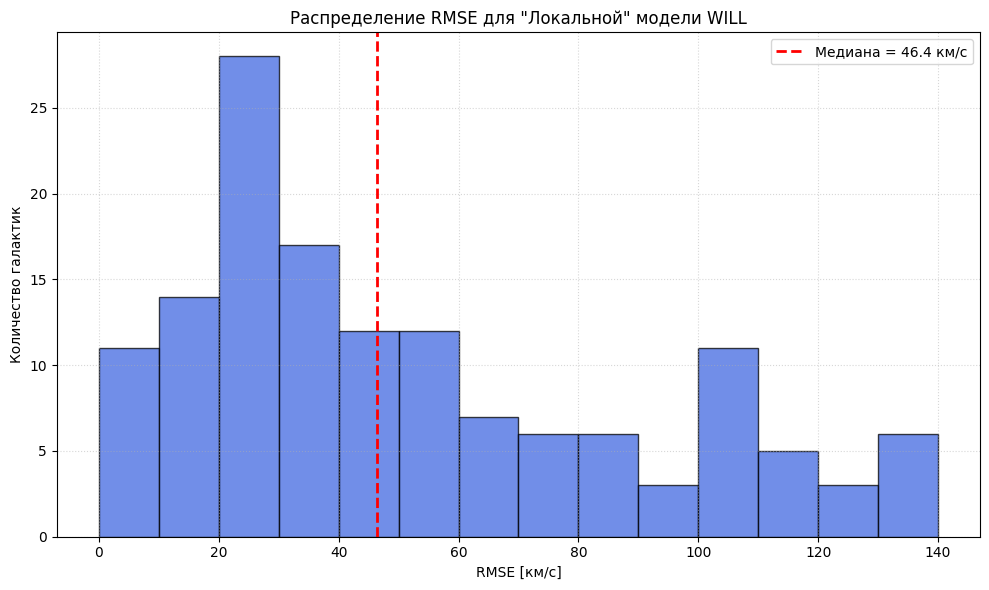

In [ ]:
# =========================================================================
# WILL: Local Differential Model (Parameter-Free)
#
# Расчет кривых вращения по уравнению:
# V_will^2 = V_bary^2 + r * d(V_bary^2)/dr
#
# Этот скрипт реализует математически корректное следствие
# из вашей теории, без интегралов и свободных параметров.
# =========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# ---------- 1. Подготовка данных (без изменений) --------------------
# Убедитесь, что путь к вашим данным указан верно
try:
    # Стандартный путь для Google Colab
    DATA_PATH = '/content/DATA'
    meta = pd.read_fwf(
        f'{DATA_PATH}/table1.dat',
        colspecs=[(0,11), (112,115)],
        names=['Galaxy', 'Qual']
    )
    curves = pd.read_table(
        f'{DATA_PATH}/table2.dat', sep=r'\s+', comment='#', header=None,
        usecols=[0, 2, 3, 5, 6, 7],
        names=['Galaxy', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
    )
except FileNotFoundError:
    print("Ошибка: Файлы данных не найдены. Пожалуйста, убедитесь, что папка 'DATA' загружена.")
    # Создаем пустые датафреймы, чтобы скрипт не падал
    meta = pd.DataFrame(columns=['Galaxy', 'Qual'])
    curves = pd.DataFrame(columns=['Galaxy', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul'])


# Приведение типов и очистка данных
meta['Qual'] = pd.to_numeric(meta['Qual'], errors='coerce')
num_cols = ['r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r', 'Vobs'], inplace=True)
curves.fillna(0, inplace=True) # Заменяем NaN на 0 для Vgas, Vdisk, Vbul

# ---------- 2. Решатель для "Локальной" модели ----------------------
def will_v_local_model(df):
    """
    Рассчитывает скорость по локальной дифференциальной формуле WILL.
    """
    df = df.sort_values('r').copy()

    # Классическая скорость от барионов (Y_star = 1.0)
    v_bary_sq = df['Vgas']**2 + (df['Vdisk']**2 + df['Vbul']**2)

    # Вычисляем производную d(V_bary^2)/dr с помощью конечных разностей
    # np.gradient - это правильный численный метод для этой задачи
    dv_sq_dr = np.gradient(v_bary_sq, df['r'])

    # Вычисляем поправочный член r * d(V_bary^2)/dr
    correction_term = df['r'] * dv_sq_dr

    # Предсказанная скорость по "локальной" формуле
    v_pred_sq = v_bary_sq + correction_term

    # Убираем отрицательные значения и берем корень
    return np.sqrt(np.clip(v_pred_sq, 0, None))


# ---------- 3. Основной цикл расчетов ---------------------------------
all_results = []
galaxies_to_run = meta[meta['Qual'] <= 2]['Galaxy'].unique()

for galaxy_name in galaxies_to_run:
    gdf = curves[curves['Galaxy'] == galaxy_name].copy()
    if len(gdf) < 5:  # Требуем минимум 5 точек для анализа хвоста
        continue

    # Рассчитываем предсказанные скорости
    v_predicted = will_v_local_model(gdf)
    gdf['Vpred'] = v_predicted

    # Убираем NaN/inf, которые могли возникнуть при расчетах
    gdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    gdf.dropna(subset=['Vobs', 'Vpred'], inplace=True)

    if len(gdf) < 5:
        continue

    # Расчет метрик
    rmse_total = np.sqrt(np.mean((gdf['Vobs'] - gdf['Vpred'])**2))

    # Расчет "хвостового" RMSE по последним 5 точкам
    tail_data = gdf.tail(5)
    rmse_tail = np.sqrt(np.mean((tail_data['Vobs'] - tail_data['Vpred'])**2))

    if np.isfinite(rmse_total) and np.isfinite(rmse_tail):
        all_results.append({
            'Galaxy': galaxy_name,
            'RMSE': rmse_total,
            'Tail_RMSE': rmse_tail,
            'Data': tail_data[['r', 'Vobs', 'Vpred']] # Сохраняем данные хвоста
        })

# Создаем итоговый DataFrame
df_results = pd.DataFrame(all_results).set_index('Galaxy').sort_values('RMSE')


# ---------- 4. Вывод результатов ---------------------------------------
if not df_results.empty:
    print("\n===== WILL: Результаты для 'Локальной' дифференциальной модели =====")
    print(f"Обработано галактик : {len(df_results)}")
    print(f"Общий RMSE (медиана): {df_results.RMSE.median():.2f} км/с")
    print(f"Хвостовой RMSE (медиана): {df_results.Tail_RMSE.median():.2f} км/с\n")

    # --- Топ-5 лучших результатов ---
    print("--- Топ-5 ЛУЧШИХ результатов (по общему RMSE) ---")
    for galaxy, row in df_results.head(5).iterrows():
        print(f"\nGalaxy: {galaxy} (RMSE: {row.RMSE:.2f}, Tail RMSE: {row.Tail_RMSE:.2f})")
        print("Последние 5 точек (r, V_obs, V_pred):")
        # Выводим данные хвоста в компактном виде
        for _, point in row.Data.iterrows():
            print(f"  r={point.r:5.2f}, Vobs={point.Vobs:6.1f}, Vpred={point.Vpred:6.1f}")

    # --- Топ-5 худших результатов ---
    print("\n\n--- Топ-5 ХУДШИХ результатов (по общему RMSE) ---")
    for galaxy, row in df_results.tail(5).iterrows():
        print(f"\nGalaxy: {galaxy} (RMSE: {row.RMSE:.2f}, Tail RMSE: {row.Tail_RMSE:.2f})")
        print("Последние 5 точек (r, V_obs, V_pred):")
        for _, point in row.Data.iterrows():
            print(f"  r={point.r:5.2f}, Vobs={point.Vobs:6.1f}, Vpred={point.Vpred:6.1f}")

    # --- График распределения RMSE ---
    plt.figure(figsize=(10, 6))
    plt.hist(df_results.RMSE, bins=np.arange(0, 150, 10), edgecolor='k', alpha=0.75, color='royalblue')
    plt.axvline(df_results.RMSE.median(), ls='--', lw=2, c='red',
                label=f"Медиана = {df_results.RMSE.median():.1f} км/с")
    plt.xlabel('RMSE [км/с]')
    plt.ylabel('Количество галактик')
    plt.title('Распределение RMSE для "Локальной" модели WILL')
    plt.legend()
    plt.grid(alpha=0.5, linestyle=':')
    plt.tight_layout()
    plt.show()

else:
    print("Не удалось обработать ни одной галактики. Проверьте пути к данным и их содержимое.")


===== WILL: Results for Integral Model =====
Fixed Parameters: Y_star = 0.5, Lambda = 2.0
Galaxies analysed: 159
Median Overall RMSE: 24.43 km/s
Median Tail RMSE: 24.08 km/s

--- Top 5 Best Fits (by Overall RMSE) ---

Galaxy: UGC07577 (RMSE: 1.85, Tail RMSE: 2.12)
Last 5 points (r, V_obs, V_pred):
  r= 0.94, Vobs=  10.7, Vpred=  13.4
  r= 1.13, Vobs=  12.4, Vpred=  14.9
  r= 1.32, Vobs=  14.1, Vpred=  16.6
  r= 1.51, Vobs=  15.9, Vpred=  17.5
  r= 1.69, Vobs=  17.8, Vpred=  17.9

Galaxy: NGC2976 (RMSE: 2.13, Tail RMSE: 1.98)
Last 5 points (r, V_obs, V_pred):
  r= 1.63, Vobs=  79.9, Vpred=  81.2
  r= 1.74, Vobs=  83.6, Vpred=  84.7
  r= 1.93, Vobs=  83.9, Vpred=  86.6
  r= 2.10, Vobs=  88.7, Vpred=  87.3
  r= 2.27, Vobs=  85.3, Vpred=  88.0

Galaxy: NGC4068 (RMSE: 3.10, Tail RMSE: 3.40)
Last 5 points (r, V_obs, V_pred):
  r= 0.64, Vobs=  13.1, Vpred=  16.6
  r= 1.06, Vobs=  22.5, Vpred=  23.2
  r= 1.48, Vobs=  30.4, Vpred=  28.5
  r= 1.91, Vobs=  36.0, Vpred=  33.3
  r= 2.33, Vobs=  41

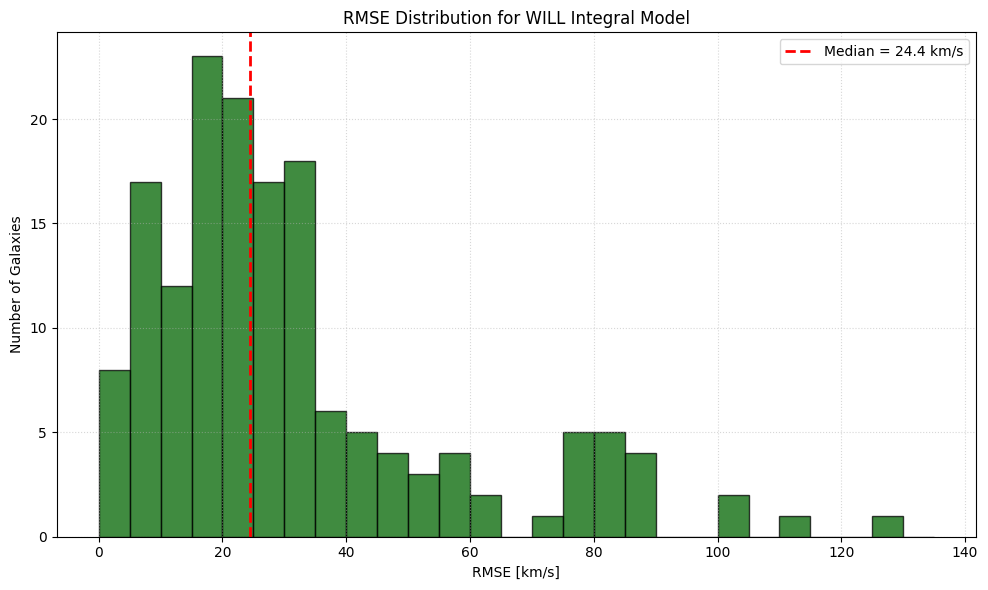

In [ ]:
# =========================================================================
# WILL: Integral Model (Fixed Parameters)
#
# This script tests the integral form of the predictive equation,
# representing a non-local, cumulative effect.
#
# Equation:
# V_will^2 = V_bary^2 + (lambda/r) * integral(V_bary^2 dr)
#
# Fixed Parameters:
# Stellar Mass-to-Light Ratio (Y_star): 0.5
# Geometric Correction (lambda): 1 / Y_star = 2.0
# =========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from IPython.display import display

# ---------- 1. Data Preparation (Unchanged) ---------------------------
# Ensure the path to your data is correct
try:
    # Standard path for Google Colab
    DATA_PATH = '/content/DATA'
    meta = pd.read_fwf(
        f'{DATA_PATH}/table1.dat',
        colspecs=[(0,11), (112,115)],
        names=['Galaxy', 'Qual']
    )
    curves = pd.read_table(
        f'{DATA_PATH}/table2.dat', sep=r'\s+', comment='#', header=None,
        usecols=[0, 2, 3, 5, 6, 7],
        names=['Galaxy', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
    )
except FileNotFoundError:
    print("Error: Data files not found. Please ensure the 'DATA' folder is uploaded.")
    # Create empty dataframes to prevent script from crashing
    meta = pd.DataFrame(columns=['Galaxy', 'Qual'])
    curves = pd.DataFrame(columns=['Galaxy', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul'])

# Type casting and data cleaning
meta['Qual'] = pd.to_numeric(meta['Qual'], errors='coerce')
num_cols = ['r', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r', 'Vobs'], inplace=True)
curves.fillna(0, inplace=True) # Replace NaNs in components with 0

# ---------- 2. Solver for the Integral Model ----------------------------
# --- MODEL PARAMETERS ---
Y_STAR = 0.5
LAMBDA = 1 / Y_STAR # As per your instruction

def will_v_integral_model(df, y_star, lambda_val):
    """
    Calculates rotation velocity using the WILL integral formula.
    """
    df = df.sort_values('r').copy()

    # Calculate classical baryonic velocity squared with the specified Y_star
    v_bary_sq = df['Vgas']**2 + y_star * (df['Vdisk']**2 + df['Vbul']**2)

    # Calculate the integral term using cumulative trapezoidal integration
    integral_term = cumulative_trapezoid(v_bary_sq, df['r'], initial=0.0)

    # Calculate the full geometric correction term, avoiding division by zero
    correction_term = np.zeros_like(df['r'], dtype=float)
    non_zero_r = df['r'] > 1e-6 # Avoid division by zero
    correction_term[non_zero_r] = lambda_val * integral_term[non_zero_r] / df.loc[non_zero_r, 'r']

    # Final predicted velocity squared
    v_pred_sq = v_bary_sq + correction_term

    # Return the velocity, clipping negative results before taking the square root
    return np.sqrt(np.clip(v_pred_sq, 0, None))


# ---------- 3. Main Calculation Loop ------------------------------------
all_results = []
galaxies_to_run = meta[meta['Qual'] <= 2]['Galaxy'].unique()

for galaxy_name in galaxies_to_run:
    gdf = curves[curves['Galaxy'] == galaxy_name].copy()
    if len(gdf) < 5:  # Require at least 5 points for tail analysis
        continue

    # Calculate predicted velocities
    v_predicted = will_v_integral_model(gdf, y_star=Y_STAR, lambda_val=LAMBDA)
    gdf['Vpred'] = v_predicted

    # Clean up any NaN/inf values that might arise
    gdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    gdf.dropna(subset=['Vobs', 'Vpred'], inplace=True)

    if len(gdf) < 5:
        continue

    # Calculate metrics
    rmse_total = np.sqrt(np.mean((gdf['Vobs'] - gdf['Vpred'])**2))

    # Calculate "tail" RMSE on the last 5 data points
    tail_data = gdf.tail(5)
    rmse_tail = np.sqrt(np.mean((tail_data['Vobs'] - tail_data['Vpred'])**2))

    if np.isfinite(rmse_total) and np.isfinite(rmse_tail):
        all_results.append({
            'Galaxy': galaxy_name,
            'RMSE': rmse_total,
            'Tail_RMSE': rmse_tail,
            'Data': tail_data[['r', 'Vobs', 'Vpred']] # Store tail data for later
        })

# Create final DataFrame
df_results = pd.DataFrame(all_results).set_index('Galaxy').sort_values('RMSE')

# ---------- 4. Results Output -------------------------------------------
if not df_results.empty:
    print("\n===== WILL: Results for Integral Model =====")
    print(f"Fixed Parameters: Y_star = {Y_STAR}, Lambda = {LAMBDA}")
    print(f"Galaxies analysed: {len(df_results)}")
    print(f"Median Overall RMSE: {df_results.RMSE.median():.2f} km/s")
    print(f"Median Tail RMSE: {df_results.Tail_RMSE.median():.2f} km/s\n")

    # --- Top 5 Best Fits ---
    print("--- Top 5 Best Fits (by Overall RMSE) ---")
    for galaxy, row in df_results.head(5).iterrows():
        print(f"\nGalaxy: {galaxy} (RMSE: {row.RMSE:.2f}, Tail RMSE: {row.Tail_RMSE:.2f})")
        print("Last 5 points (r, V_obs, V_pred):")
        for _, point in row.Data.iterrows():
            print(f"  r={point.r:5.2f}, Vobs={point.Vobs:6.1f}, Vpred={point.Vpred:6.1f}")

    # --- Top 5 Worst Fits ---
    print("\n\n--- Top 5 Worst Fits (by Overall RMSE) ---")
    for galaxy, row in df_results.tail(5).iterrows():
        print(f"\nGalaxy: {galaxy} (RMSE: {row.RMSE:.2f}, Tail RMSE: {row.Tail_RMSE:.2f})")
        print("Last 5 points (r, V_obs, V_pred):")
        for _, point in row.Data.iterrows():
            print(f"  r={point.r:5.2f}, Vobs={point.Vobs:6.1f}, Vpred={point.Vpred:6.1f}")

    # --- RMSE Distribution Plot ---
    plt.figure(figsize=(10, 6))
    plt.hist(df_results.RMSE, bins=np.arange(0, df_results.RMSE.max() + 10, 5), edgecolor='black', alpha=0.75, color='darkgreen')
    plt.axvline(df_results.RMSE.median(), ls='--', lw=2, c='red',
                label=f"Median = {df_results.RMSE.median():.1f} km/s")
    plt.xlabel('RMSE [km/s]')
    plt.ylabel('Number of Galaxies')
    plt.title('RMSE Distribution for WILL Integral Model')
    plt.legend()
    plt.grid(alpha=0.5, linestyle=':')
    plt.tight_layout()
    plt.show()

else:
    print("Could not process any galaxies. Please check data paths and content.")

In [4]:
# =============================================================================
# SPARC Data Verification Script
#
# Purpose: To load `table1.dat` and `table2.dat`, select a test galaxy,
# and print its properties to ensure the data is parsed correctly
# according to the ReadMe file.
# =============================================================================

import pandas as pd
import numpy as np

# --- 1. Define Data Paths and Test Galaxy ---
# Ensure the path to your data is correct
DATA_PATH = '/content/DATA'
META_FILE = f'{DATA_PATH}/table1.dat'
CURVE_FILE = f'{DATA_PATH}/table2.dat'

# We'll use NGC2976 as a test case since it was a good fit in the last run.
TEST_GALAXY_NAME = 'NGC2976'


# --- 2. Load Data Files Based on ReadMe Specifications ---
try:
    print("Attempting to load data files...")

    # Load table1.dat (Galaxy Properties) using fixed-width format
    # The columns and names are taken directly from the ReadMe file.
    galaxy_properties = pd.read_fwf(
        META_FILE,
        colspecs=[
            (0, 11),   # Name
            (12, 14),  # Type
            (15, 21),  # Dist
            (40, 47),  # L3.6
            (86, 93),  # MHI
            (100, 105) # Vflat
        ],
        names=['Name', 'Type', 'Dist', 'L3.6', 'MHI', 'Vflat'],
        header=None
    )
    print(f"Successfully loaded `table1.dat`. Found {len(galaxy_properties)} entries.")

    # Load table2.dat (Rotation Curve Data)
    # The columns are selected based on the ReadMe.
    rotation_curves = pd.read_table(
        CURVE_FILE,
        sep=r'\s+',
        comment='#',
        header=None,
        usecols=[0, 2, 3, 5, 6, 7],
        names=['Name', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbulge']
    )
    print(f"Successfully loaded `table2.dat`. Found {len(rotation_curves)} data points.")

except FileNotFoundError:
    print(f"\nERROR: Data files not found in '{DATA_PATH}'.")
    print("Please ensure your data is uploaded and the path is correct.")
    # Exit gracefully if data is not found
    galaxy_properties = pd.DataFrame()
    rotation_curves = pd.DataFrame()


# --- 3. Perform Verification ---
if not galaxy_properties.empty and not rotation_curves.empty:

    print(f"\n--- Verifying data for galaxy: {TEST_GALAXY_NAME} ---")

    # --- Verification for table1.dat ---
    galaxy_data = galaxy_properties[galaxy_properties['Name'] == TEST_GALAXY_NAME]

    if not galaxy_data.empty:
        print("\n[SUCCESS] Found galaxy in `table1.dat` (Galaxy Properties).")
        print("Extracted Properties:")
        # .iloc[0] gets the first (and only) row of data
        print(f"  - Galaxy Name: {galaxy_data['Name'].iloc[0]}")
        print(f"  - Hubble Type: {galaxy_data['Type'].iloc[0]}")
        print(f"  - Distance (Mpc): {galaxy_data['Dist'].iloc[0]}")
        print(f"  - Luminosity (Lsun): {galaxy_data['L3.6'].iloc[0]} G") # G = 10^9
        print(f"  - HI Gas Mass (Msun): {galaxy_data['MHI'].iloc[0]} G") # G = 10^9
        print(f"  - Flat Velocity (km/s): {galaxy_data['Vflat'].iloc[0]}")
    else:
        print(f"\n[ERROR] Could not find galaxy '{TEST_GALAXY_NAME}' in `table1.dat`.")


    # --- Verification for table2.dat ---
    curve_data = rotation_curves[rotation_curves['Name'] == TEST_GALAXY_NAME]

    if not curve_data.empty:
        print("\n[SUCCESS] Found galaxy in `table2.dat` (Rotation Curves).")
        print(f"Total data points for this galaxy: {len(curve_data)}")

        print("\nFirst 3 data points:")
        display(curve_data.head(3))

        print("\nLast 3 data points:")
        display(curve_data.tail(3))
    else:
        print(f"\n[ERROR] Could not find galaxy '{TEST_GALAXY_NAME}' in `table2.dat`.")

Attempting to load data files...
Successfully loaded `table1.dat`. Found 175 entries.
Successfully loaded `table2.dat`. Found 3391 data points.

--- Verifying data for galaxy: NGC2976 ---

[SUCCESS] Found galaxy in `table1.dat` (Galaxy Properties).
Extracted Properties:
  - Galaxy Name: NGC2976
  - Hubble Type: 5
  - Distance (Mpc): 3.58
  - Luminosity (Lsun): 3.371 G
  - HI Gas Mass (Msun): 0.172 G
  - Flat Velocity (km/s): 85.4

[SUCCESS] Found galaxy in `table2.dat` (Rotation Curves).
Total data points for this galaxy: 27

First 3 data points:


,Name,r,Vobs,Vgas,Vdisk,Vbulge
947,NGC2976,0.11,6.8,1.06,11.98,0.0
948,NGC2976,0.17,9.5,1.76,15.44,0.0
949,NGC2976,0.24,14.0,2.47,19.52,0.0



Last 3 data points:


,Name,r,Vobs,Vgas,Vdisk,Vbulge
971,NGC2976,1.93,83.9,29.44,78.52,0.0
972,NGC2976,2.10,88.7,29.75,75.56,0.0
973,NGC2976,2.27,85.3,29.85,73.66,0.0


--- 1. Loading and Preparing Data ---
Successfully loaded `table1.dat`.
Successfully loaded `table2.dat`.

--- 2. Optimizing Parameters for Each Galaxy ---
This process may take several minutes...
  ...processed 25/175 galaxies.
  ...processed 50/175 galaxies.
  ...processed 75/175 galaxies.
  ...processed 100/175 galaxies.
  ...processed 125/175 galaxies.
  ...processed 150/175 galaxies.
  ...processed 175/175 galaxies.

--- 3. Merging Fit Results with Galaxy Properties ---
Successfully created final dataframe with 171 galaxies.

Sample of the final merged data:


,Type,Dist,L3.6,Reff,SBeff,MHI,Vflat,Y_star_best,Lambda_best,RMSE_best
Name,,,,,,,,,,
CamB,10,3.36,0.075,1.21,7.89,0.012,0.0,0.100000,2.600433,2.424517
D564-8,10,8.79,0.033,0.72,10.11,0.029,0.0,0.820532,5.698455,1.263898
D631-7,10,7.72,0.196,1.22,20.93,0.290,57.7,0.100000,6.399332,6.653116
DDO064,10,6.80,0.157,1.20,17.41,0.211,46.1,1.335277,2.880360,2.893304
DDO154,10,4.04,0.053,0.65,19.99,0.275,47.0,0.378578,8.402519,1.937639



--- 4. Generating Correlation Plots ---


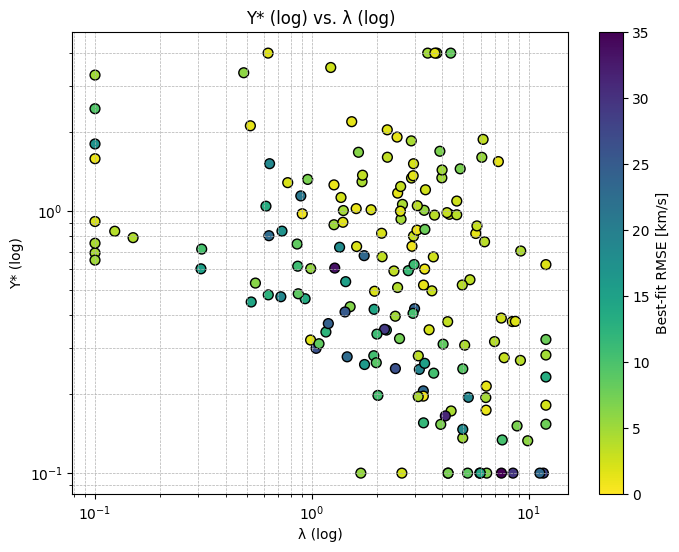

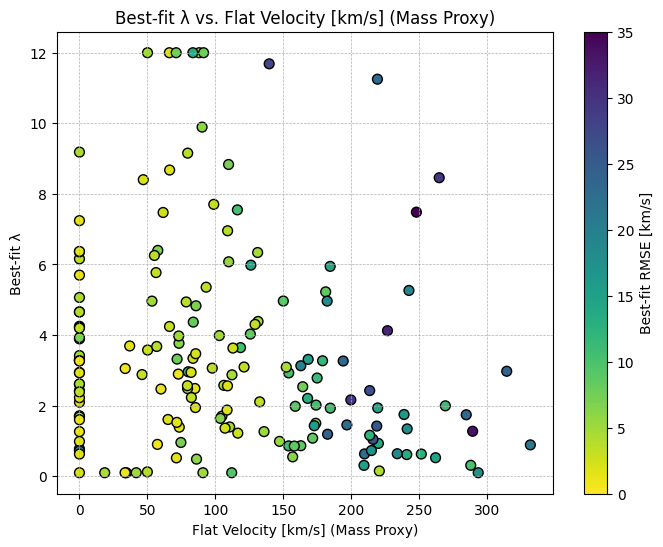

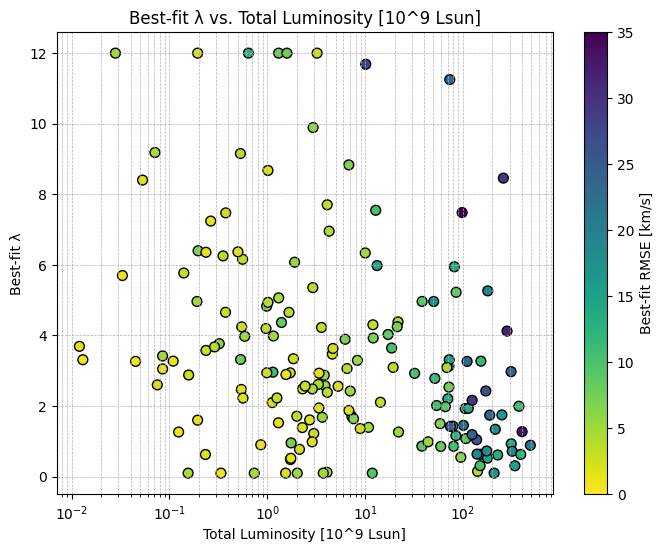

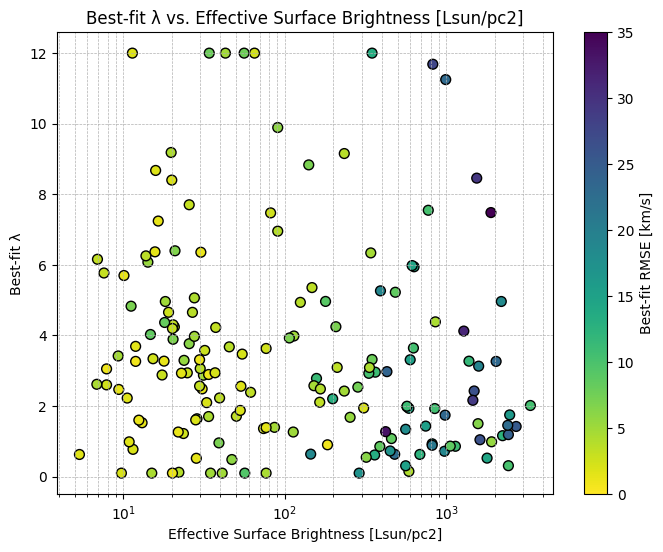

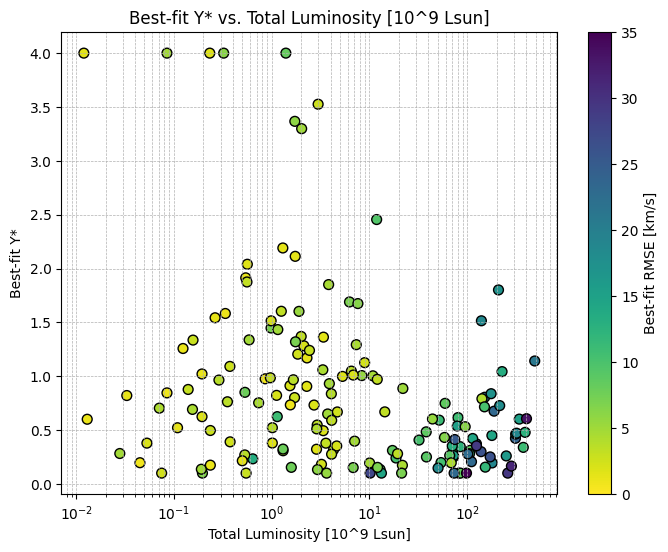

In [6]:
# =============================================================================
# WILL Framework: Correlation Analysis Script (Corrected)
#
# Purpose:
# 1. Finds the best-fit parameters (lambda, Y_star) for each SPARC galaxy
#    by minimizing the RMSE of the integral model.
# 2. Merges these results with the physical properties from table1.dat.
# 3. Generates a series of plots to investigate correlations between the
#    best-fit parameters and galaxy properties.
#
# CORRECTION: Fixed a KeyError by changing 'Vbul' to 'Vbulge'.
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import differential_evolution
from IPython.display import display
import warnings

# --- 0. Setup ---
warnings.filterwarnings("ignore")

# --- 1. Data Loading and Preparation ---
print("--- 1. Loading and Preparing Data ---")
DATA_PATH = '/content/DATA'
META_FILE = f'{DATA_PATH}/table1.dat'
CURVE_FILE = f'{DATA_PATH}/table2.dat'

try:
    props = pd.read_fwf(
        META_FILE,
        colspecs=[
            (0, 11), (12, 14), (15, 21), (40, 47),
            (56, 61), (62, 70), (86, 93), (100, 105)
        ],
        names=['Name', 'Type', 'Dist', 'L3.6', 'Reff', 'SBeff', 'MHI', 'Vflat'],
        header=None
    ).set_index('Name')
    print("Successfully loaded `table1.dat`.")

    curves = pd.read_table(
        CURVE_FILE, sep=r'\s+', comment='#', header=None,
        usecols=[0, 2, 3, 5, 6, 7],
        names=['Name', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbulge']
    )
    print("Successfully loaded `table2.dat`.")

    curves.fillna(0, inplace=True)
    curves.dropna(subset=['r', 'Vobs'], inplace=True)

except FileNotFoundError:
    print(f"\nERROR: Data files not found in '{DATA_PATH}'. Script cannot continue.")
    props = pd.DataFrame()
    curves = pd.DataFrame()

# --- 2. Core Model and Optimization Functions ---
# CORRECTED a typo in the function signature: Vbul -> Vbulge
def will_v_integral(r, Vgas, Vdisk, Vbulge, y_star, lambda_val):
    """Calculates rotation velocity using the WILL integral formula."""
    # CORRECTED a typo in the calculation: Vbul -> Vbulge
    v_bary_sq = Vgas**2 + y_star * (Vdisk**2 + Vbulge**2)
    integral = cumulative_trapezoid(v_bary_sq, r, initial=0.0)

    correction = np.zeros_like(r, dtype=float)
    non_zero_r = r > 1e-6
    correction[non_zero_r] = lambda_val * integral[non_zero_r] / r[non_zero_r]

    v_pred_sq = v_bary_sq + correction
    return np.sqrt(np.clip(v_pred_sq, 0, None))

def objective_function(params, df):
    """The function to be minimized. Returns the RMSE."""
    y_star, lambda_val = params
    # CORRECTED a typo in the column name: 'Vbul' -> 'Vbulge'
    v_pred = will_v_integral(df['r'].values, df['Vgas'].values, df['Vdisk'].values,
                               df['Vbulge'].values, y_star, lambda_val)

    v_pred_clean = np.nan_to_num(v_pred, nan=0.0, posinf=0.0, neginf=0.0)
    return np.sqrt(np.mean((df['Vobs'].values - v_pred_clean)**2))

def fit_galaxy(df):
    """Finds the best-fit (y_star, lambda) for a single galaxy."""
    bounds = [(0.1, 4.0), (0.1, 12.0)]
    result = differential_evolution(objective_function, bounds, args=(df,), tol=0.01)

    best_params = result.x
    best_rmse = result.fun
    return best_params[0], best_params[1], best_rmse

# --- 3. Main Loop: Fit All Galaxies ---
if not curves.empty:
    print("\n--- 2. Optimizing Parameters for Each Galaxy ---")
    print("This process may take several minutes...")

    fit_results = []
    galaxies_to_run = props[props.index.isin(curves['Name'].unique())].index

    for i, galaxy_name in enumerate(galaxies_to_run):
        gdf = curves[curves['Name'] == galaxy_name].sort_values('r')
        if len(gdf) < 5:
            continue

        y_star_best, lambda_best, rmse_best = fit_galaxy(gdf)

        fit_results.append({
            'Name': galaxy_name,
            'Y_star_best': y_star_best,
            'Lambda_best': lambda_best,
            'RMSE_best': rmse_best
        })

        if (i + 1) % 25 == 0:
            print(f"  ...processed {i+1}/{len(galaxies_to_run)} galaxies.")

    # --- 4. Merge Results and Final DataFrame ---
    print("\n--- 3. Merging Fit Results with Galaxy Properties ---")
    df_fits = pd.DataFrame(fit_results).set_index('Name')
    df_final = props.join(df_fits, how='inner')
    df_final.dropna(inplace=True)
    print(f"Successfully created final dataframe with {len(df_final)} galaxies.")

    print("\nSample of the final merged data:")
    display(df_final.head())

    # --- 5. Generate Correlation Plots ---
    print("\n--- 4. Generating Correlation Plots ---")

    def plot_correlation(df, x_col, y_col, x_label, y_label, x_log=False, y_log=False):
        plt.figure(figsize=(8, 6))
        sc = plt.scatter(df[x_col], df[y_col], c=df['RMSE_best'], cmap='viridis_r',
                         edgecolor='black', s=50, vmin=0, vmax=35)
        plt.colorbar(sc, label='Best-fit RMSE [km/s]')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        if x_log: plt.xscale('log')
        if y_log: plt.yscale('log')
        plt.title(f'{y_label} vs. {x_label}')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.show()

    plot_correlation(df_final, 'Lambda_best', 'Y_star_best',
                     'λ (log)', 'Y* (log)', x_log=True, y_log=True)

    plot_correlation(df_final, 'Vflat', 'Lambda_best',
                     'Flat Velocity [km/s] (Mass Proxy)', 'Best-fit λ')

    plot_correlation(df_final, 'L3.6', 'Lambda_best',
                     'Total Luminosity [10^9 Lsun]', 'Best-fit λ', x_log=True)

    plot_correlation(df_final, 'SBeff', 'Lambda_best',
                     'Effective Surface Brightness [Lsun/pc2]', 'Best-fit λ', x_log=True)

    plot_correlation(df_final, 'L3.6', 'Y_star_best',
                     'Total Luminosity [10^9 Lsun]', 'Best-fit Y*', x_log=True)
else:
    print("Script terminated because data files were not found.")

In [7]:
# =============================================================================
# SPARC Data Sampler Script
#
# Purpose: To load `table1.dat` and display a sample of galaxies with
# diverse morphological types, confirming we can select galaxies based
# on their physical properties.
# =============================================================================

import pandas as pd
import numpy as np
from IPython.display import display

# --- 1. Define Data Path and Load Data ---
DATA_PATH = '/content/DATA'
META_FILE = f'{DATA_PATH}/table1.dat'

try:
    print("Attempting to load `table1.dat`...")
    props = pd.read_fwf(
        META_FILE,
        colspecs=[(0, 11), (12, 14), (15, 21), (40, 47), (86, 93), (100, 105)],
        names=['Name', 'Type', 'Dist', 'L3.6', 'MHI', 'Vflat']
    )
    print("Successfully loaded data.")

except FileNotFoundError:
    print(f"\nERROR: Data file not found in '{DATA_PATH}'.")
    props = pd.DataFrame()

# --- 2. Create a Diverse Sample ---
if not props.empty:
    # Define the mapping from numerical type to Hubble type (from ReadMe)
    hubble_type_map = {
        0: 'S0', 1: 'Sa', 2: 'Sab', 3: 'Sb', 4: 'Sbc', 5: 'Sc',
        6: 'Scd', 7: 'Sd', 8: 'Sdm', 9: 'Sm', 10: 'Im', 11: 'BCD'
    }

    # Create a new column with the human-readable Hubble Type
    props['Hubble_Type'] = props['Type'].map(hubble_type_map)

    # Group by the numerical type and take the first galaxy from each group
    diverse_sample = props.groupby('Type').first()

    # Add the readable Hubble Type to the sample as well
    diverse_sample['Hubble_Type'] = diverse_sample.index.map(hubble_type_map)

    # Reorder columns for better readability
    diverse_sample = diverse_sample[['Hubble_Type', 'Name', 'Dist', 'L3.6', 'MHI', 'Vflat']]

    # --- 3. Display the Result ---
    print("\n--- A Sample of Galaxies with Diverse Morphological Types ---")
    display(diverse_sample)

else:
    print("Script terminated because data files were not found.")

Attempting to load `table1.dat`...
Successfully loaded data.

--- A Sample of Galaxies with Diverse Morphological Types ---


,Hubble_Type,Name,Dist,L3.6,MHI,Vflat
Type,,,,,,
0,S0,NGC4138,18.00,44.111,1.483,147.3
1,Sa,UGC03546,28.70,101.336,2.675,196.9
2,Sab,NGC7814,14.40,74.529,1.070,218.9
3,Sb,NGC0891,9.91,138.340,4.462,216.1
4,Sbc,ESO079-G014,28.70,51.733,3.140,175.0
5,Sc,F568-1,90.70,6.252,4.498,0.0
6,Scd,NGC0100,13.50,3.232,1.990,88.1
7,Sd,ESO116-G012,13.00,4.292,1.083,109.1
8,Sdm,UGC00128,64.50,12.020,7.431,129.3


--- 1. Loading and Preparing Data ---
Successfully loaded `table1.dat`.
Successfully loaded `table2.dat`.

--- 2. Optimizing Parameters for Each Galaxy ---
This process may take several minutes...
  ...processed 25/175 galaxies.
  ...processed 50/175 galaxies.
  ...processed 75/175 galaxies.
  ...processed 100/175 galaxies.
  ...processed 125/175 galaxies.
  ...processed 150/175 galaxies.
  ...processed 175/175 galaxies.

--- 3. Merging Fit Results with Galaxy Properties ---
Successfully created final dataframe with 171 galaxies.

Sample of the final merged data:


,Type,Dist,L3.6,Reff,SBeff,MHI,Vflat,Y_star_best,Lambda_best,RMSE_best
Name,,,,,,,,,,
CamB,10,3.36,0.075,1.21,7.89,0.012,0.0,0.100000,2.600437,2.424517
D564-8,10,8.79,0.033,0.72,10.11,0.029,0.0,0.820529,5.698479,1.263898
D631-7,10,7.72,0.196,1.22,20.93,0.290,57.7,0.100000,6.399330,6.653116
DDO064,10,6.80,0.157,1.20,17.41,0.211,46.1,1.335284,2.880343,2.893304
DDO154,10,4.04,0.053,0.65,19.99,0.275,47.0,0.378574,8.402551,1.937639



--- 4. Generating Correlation Plots ---


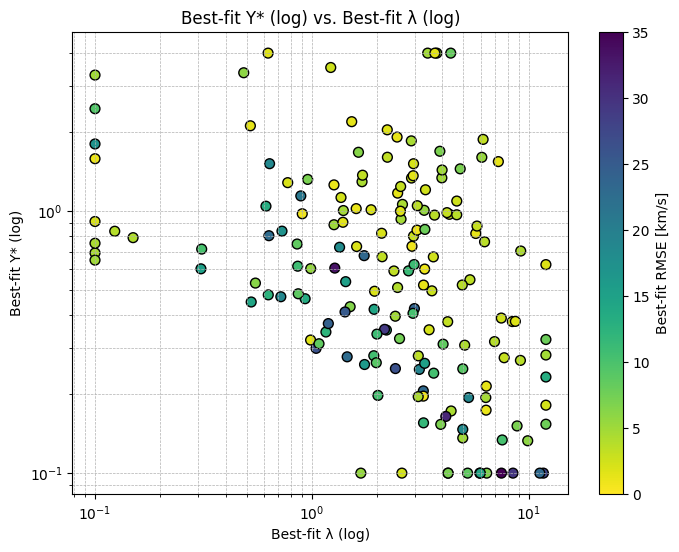

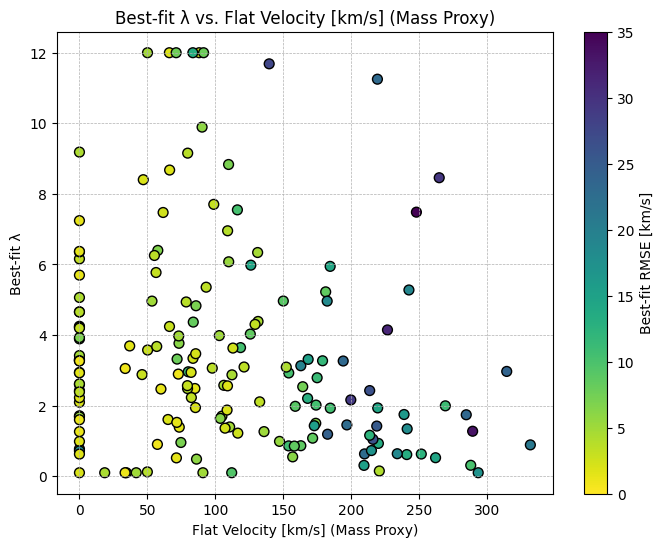

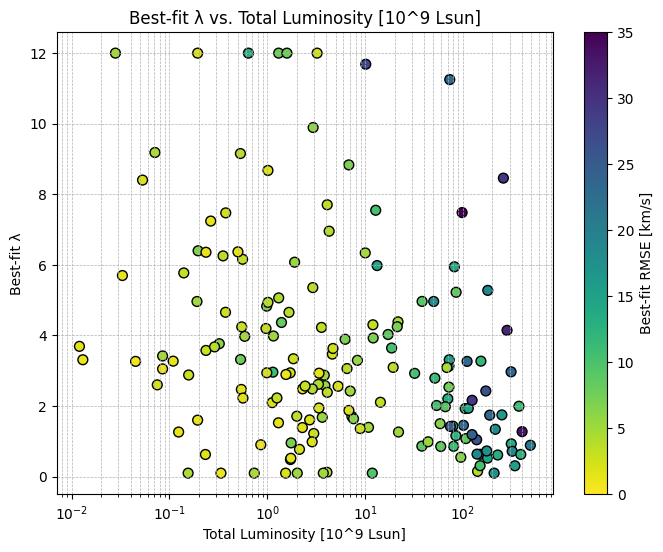

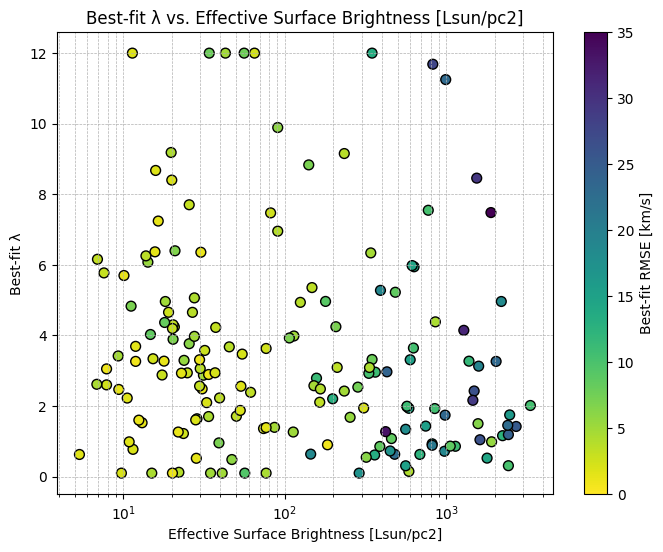

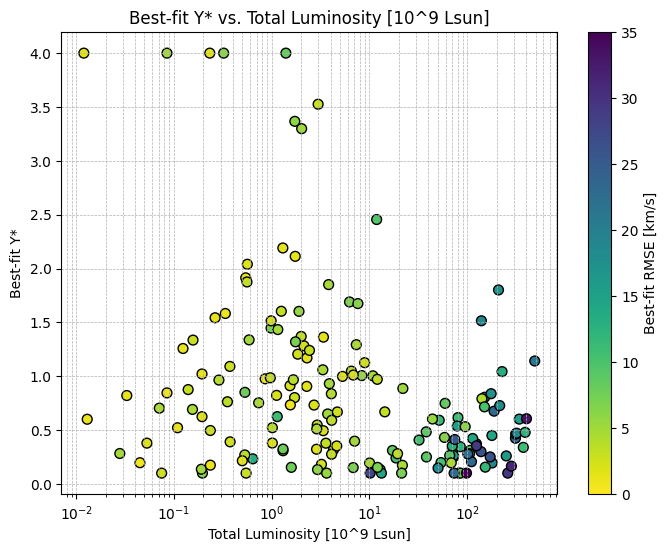

In [8]:
# =============================================================================
# WILL Framework: Correlation Analysis Script
#
# Purpose:
# 1. Finds the best-fit parameters (lambda, Y_star) for each SPARC galaxy
#    by minimizing the RMSE of the integral model.
# 2. Merges these results with the physical properties from table1.dat.
# 3. Generates a series of plots to investigate correlations between the
#    best-fit parameters and galaxy properties.
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import differential_evolution
from IPython.display import display
import warnings

# --- 0. Setup ---
# Suppress warnings from optimization, which can be noisy
warnings.filterwarnings("ignore")


# --- 1. Data Loading and Preparation ---
print("--- 1. Loading and Preparing Data ---")
# Ensure the path to your data is correct
DATA_PATH = '/content/DATA'
META_FILE = f'{DATA_PATH}/table1.dat'
CURVE_FILE = f'{DATA_PATH}/table2.dat'

try:
    # Load table1.dat (Galaxy Properties) using fixed-width format from ReadMe
    props = pd.read_fwf(
        META_FILE,
        colspecs=[
            (0, 11), (12, 14), (15, 21), (40, 47),
            (56, 61), (62, 70), (86, 93), (100, 105)
        ],
        names=['Name', 'Type', 'Dist', 'L3.6', 'Reff', 'SBeff', 'MHI', 'Vflat'],
        header=None
    ).set_index('Name')
    print("Successfully loaded `table1.dat`.")

    # Load table2.dat (Rotation Curve Data)
    curves = pd.read_table(
        CURVE_FILE, sep=r'\s+', comment='#', header=None,
        usecols=[0, 2, 3, 5, 6, 7],
        names=['Name', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbulge']
    )
    print("Successfully loaded `table2.dat`.")

    # Clean up data
    curves.fillna(0, inplace=True)
    curves.dropna(subset=['r', 'Vobs'], inplace=True)

except FileNotFoundError:
    print(f"\nERROR: Data files not found in '{DATA_PATH}'. Script cannot continue.")
    props = pd.DataFrame() # Create empty DF to prevent crash
    curves = pd.DataFrame()


# --- 2. Core Model and Optimization Functions ---
def will_v_integral(r, Vgas, Vdisk, Vbulge, y_star, lambda_val):
    """Calculates rotation velocity using the WILL integral formula."""
    v_bary_sq = Vgas**2 + y_star * (Vdisk**2 + Vbulge**2)
    integral = cumulative_trapezoid(v_bary_sq, r, initial=0.0)

    correction = np.zeros_like(r, dtype=float)
    non_zero_r = r > 1e-6
    correction[non_zero_r] = lambda_val * integral[non_zero_r] / r[non_zero_r]

    v_pred_sq = v_bary_sq + correction
    return np.sqrt(np.clip(v_pred_sq, 0, None))

def objective_function(params, df):
    """The function to be minimized. Returns the RMSE."""
    y_star, lambda_val = params
    v_pred = will_v_integral(df['r'].values, df['Vgas'].values, df['Vdisk'].values,
                               df['Vbulge'].values, y_star, lambda_val)

    # Clean up any potential NaN/inf values from the prediction
    v_pred_clean = np.nan_to_num(v_pred, nan=0.0, posinf=0.0, neginf=0.0)

    return np.sqrt(np.mean((df['Vobs'].values - v_pred_clean)**2))

def fit_galaxy(df):
    """Finds the best-fit (y_star, lambda) for a single galaxy."""
    # Parameter bounds: [(y_star_min, y_star_max), (lambda_min, lambda_max)]
    bounds = [(0.1, 4.0), (0.1, 12.0)]

    # differential_evolution is a robust global optimizer
    result = differential_evolution(objective_function, bounds, args=(df,), tol=0.01)

    best_params = result.x
    best_rmse = result.fun
    return best_params[0], best_params[1], best_rmse


# --- 3. Main Loop: Fit All Galaxies ---
if not curves.empty:
    print("\n--- 2. Optimizing Parameters for Each Galaxy ---")
    print("This process may take several minutes...")

    fit_results = []
    galaxies_to_run = props[props.index.isin(curves['Name'].unique())].index

    for i, galaxy_name in enumerate(galaxies_to_run):
        gdf = curves[curves['Name'] == galaxy_name].sort_values('r')
        if len(gdf) < 5:
            continue

        y_star_best, lambda_best, rmse_best = fit_galaxy(gdf)

        fit_results.append({
            'Name': galaxy_name,
            'Y_star_best': y_star_best,
            'Lambda_best': lambda_best,
            'RMSE_best': rmse_best
        })

        # Progress indicator
        if (i + 1) % 25 == 0:
            print(f"  ...processed {i+1}/{len(galaxies_to_run)} galaxies.")

    # --- 4. Merge Results and Final DataFrame ---
    print("\n--- 3. Merging Fit Results with Galaxy Properties ---")
    df_fits = pd.DataFrame(fit_results).set_index('Name')
    df_final = props.join(df_fits, how='inner')
    df_final.dropna(inplace=True)
    print(f"Successfully created final dataframe with {len(df_final)} galaxies.")

    print("\nSample of the final merged data:")
    display(df_final.head())


    # --- 5. Generate Correlation Plots ---
    print("\n--- 4. Generating Correlation Plots ---")

    # Helper function for plotting
    def plot_correlation(df, x_col, y_col, x_label, y_label, x_log=False, y_log=False):
        plt.figure(figsize=(8, 6))
        sc = plt.scatter(df[x_col], df[y_col], c=df['RMSE_best'], cmap='viridis_r',
                         edgecolor='black', s=50, vmin=0, vmax=35)
        plt.colorbar(sc, label='Best-fit RMSE [km/s]')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        if x_log:
            plt.xscale('log')
        if y_log:
            plt.yscale('log')
        plt.title(f'{y_label} vs. {x_label}')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.show()

    # Plot 1: Recreate the Lambda vs Y_star plot
    plot_correlation(df_final, 'Lambda_best', 'Y_star_best',
                     'Best-fit λ (log)', 'Best-fit Y* (log)', x_log=True, y_log=True)

    # Plot 2: How does Lambda depend on total galaxy mass (Vflat)?
    plot_correlation(df_final, 'Vflat', 'Lambda_best',
                     'Flat Velocity [km/s] (Mass Proxy)', 'Best-fit λ')

    # Plot 3: How does Lambda depend on luminosity?
    plot_correlation(df_final, 'L3.6', 'Lambda_best',
                     'Total Luminosity [10^9 Lsun]', 'Best-fit λ', x_log=True)

    # Plot 4: How does Lambda depend on surface brightness?
    plot_correlation(df_final, 'SBeff', 'Lambda_best',
                     'Effective Surface Brightness [Lsun/pc2]', 'Best-fit λ', x_log=True)

    # Plot 5: How does Y_star depend on luminosity?
    plot_correlation(df_final, 'L3.6', 'Y_star_best',
                     'Total Luminosity [10^9 Lsun]', 'Best-fit Y*', x_log=True)

else:
    print("Script terminated because data files were not found.")

--- 1. Loading and Preparing Data ---
Successfully loaded `table1.dat`.
Successfully loaded `table2.dat`.

--- 2. Optimizing Parameters for Each Galaxy ---
This process may take several minutes...
  ...processed 25/175 galaxies.
  ...processed 50/175 galaxies.
  ...processed 75/175 galaxies.
  ...processed 100/175 galaxies.
  ...processed 125/175 galaxies.
  ...processed 150/175 galaxies.
  ...processed 175/175 galaxies.

--- 3. Merging Fit Results with Galaxy Properties ---
Successfully created final dataframe with 171 galaxies.

Sample of the final merged data (now includes NRMSE):


,Type,Dist,L3.6,Reff,SBeff,MHI,Vflat,Y_star_best,Lambda_best,RMSE_best,NRMSE_best
Name,,,,,,,,,,,
CamB,10,3.36,0.075,1.21,7.89,0.012,0.0,0.100000,2.600433,2.424517,0.222910
D564-8,10,8.79,0.033,0.72,10.11,0.029,0.0,0.820528,5.698483,1.263898,0.066323
D631-7,10,7.72,0.196,1.22,20.93,0.290,57.7,0.100000,6.399330,6.653116,0.154587
DDO064,10,6.80,0.157,1.20,17.41,0.211,46.1,1.335274,2.880368,2.893304,0.088929
DDO154,10,4.04,0.053,0.65,19.99,0.275,47.0,0.378577,8.402532,1.937639,0.050746



--- 4. Generating Correlation Plots (Colored by NRMSE) ---


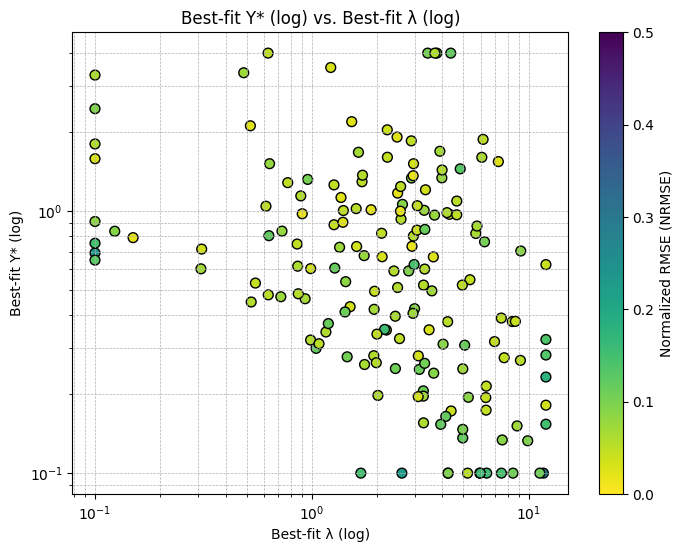

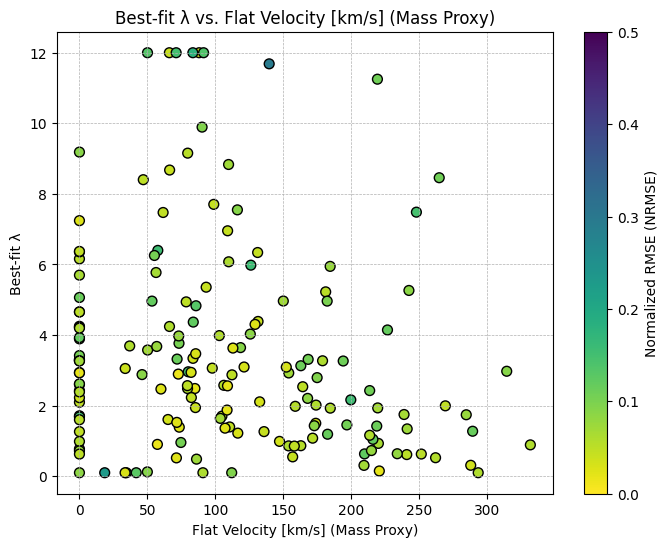

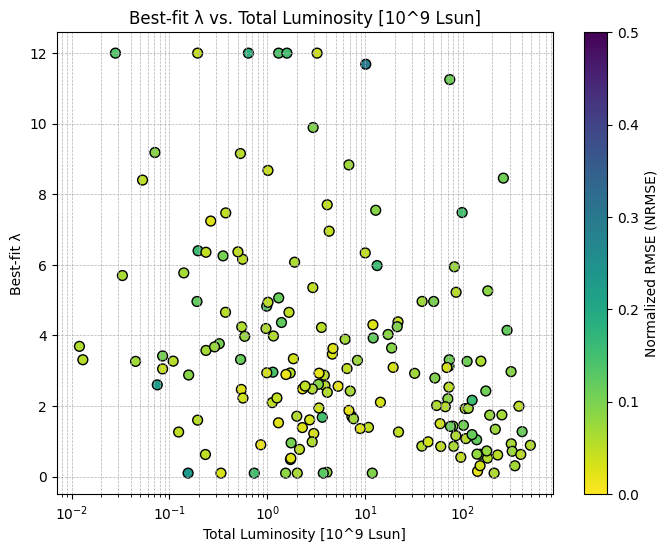

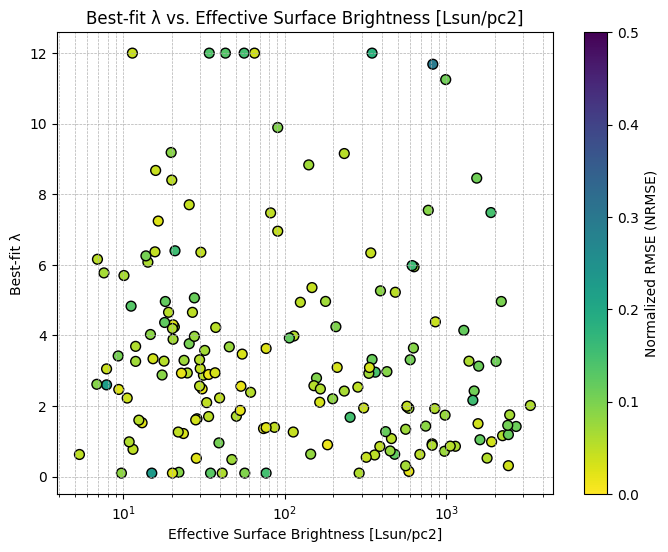

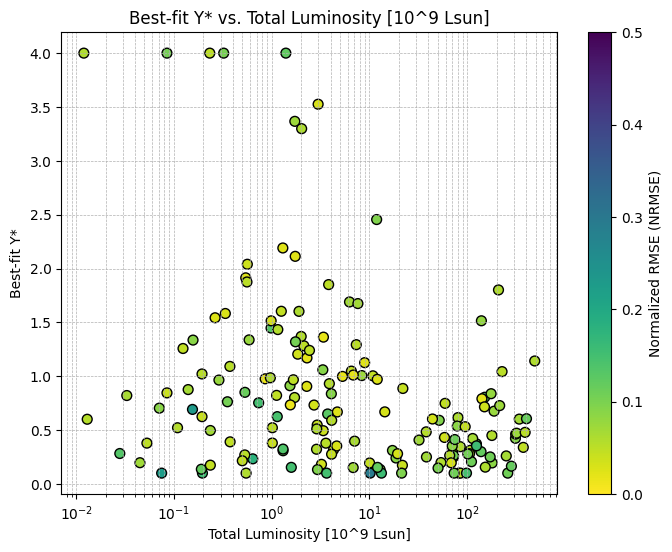

In [9]:
# =============================================================================
# WILL Framework: Robust Correlation Analysis Script (v3.0)
#
# Purpose:
# 1. Finds the best-fit parameters (lambda, Y_star) for each SPARC galaxy
#    by minimizing the absolute RMSE (for numerical stability).
# 2. Calculates a robust Normalized RMSE (NRMSE = RMSE / mean(V_obs))
#    to measure the relative, percentage-based error.
# 3. Merges these results with the physical properties from table1.dat.
# 4. Generates plots colored by NRMSE for a fair, insightful analysis.
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import differential_evolution
from IPython.display import display
import warnings

# --- 0. Setup ---
# Suppress warnings from optimization, which can be noisy
warnings.filterwarnings("ignore")


# --- 1. Data Loading and Preparation ---
print("--- 1. Loading and Preparing Data ---")
# Ensure the path to your data is correct
DATA_PATH = '/content/DATA'
META_FILE = f'{DATA_PATH}/table1.dat'
CURVE_FILE = f'{DATA_PATH}/table2.dat'

try:
    # Load table1.dat (Galaxy Properties)
    props = pd.read_fwf(
        META_FILE,
        colspecs=[
            (0, 11), (12, 14), (15, 21), (40, 47),
            (56, 61), (62, 70), (86, 93), (100, 105)
        ],
        names=['Name', 'Type', 'Dist', 'L3.6', 'Reff', 'SBeff', 'MHI', 'Vflat'],
        header=None
    ).set_index('Name')
    print("Successfully loaded `table1.dat`.")

    # Load table2.dat (Rotation Curve Data)
    curves = pd.read_table(
        CURVE_FILE, sep=r'\s+', comment='#', header=None,
        usecols=[0, 2, 3, 5, 6, 7],
        names=['Name', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbulge']
    )
    print("Successfully loaded `table2.dat`.")

    # Clean up data
    curves.fillna(0, inplace=True)
    curves.dropna(subset=['r', 'Vobs'], inplace=True)

except FileNotFoundError:
    print(f"\nERROR: Data files not found in '{DATA_PATH}'. Script cannot continue.")
    props = pd.DataFrame() # Create empty DF to prevent crash
    curves = pd.DataFrame()


# --- 2. Core Model and Optimization Functions ---
def will_v_integral(r, Vgas, Vdisk, Vbulge, y_star, lambda_val):
    """Calculates rotation velocity using the WILL integral formula."""
    v_bary_sq = Vgas**2 + y_star * (Vdisk**2 + Vbulge**2)
    integral = cumulative_trapezoid(v_bary_sq, r, initial=0.0)

    correction = np.zeros_like(r, dtype=float)
    non_zero_r = r > 1e-6
    correction[non_zero_r] = lambda_val * integral[non_zero_r] / r[non_zero_r]

    v_pred_sq = v_bary_sq + correction
    return np.sqrt(np.clip(v_pred_sq, 0, None))

def objective_function(params, df):
    """The function to be minimized. Returns the absolute RMSE."""
    y_star, lambda_val = params
    v_pred = will_v_integral(df['r'].values, df['Vgas'].values, df['Vdisk'].values,
                               df['Vbulge'].values, y_star, lambda_val)

    v_pred_clean = np.nan_to_num(v_pred, nan=0.0, posinf=0.0, neginf=0.0)
    return np.sqrt(np.mean((df['Vobs'].values - v_pred_clean)**2))

def fit_galaxy(df):
    """Finds the best-fit (y_star, lambda) for a single galaxy."""
    bounds = [(0.1, 4.0), (0.1, 12.0)]
    result = differential_evolution(objective_function, bounds, args=(df,), tol=0.01, seed=42)

    best_params = result.x
    best_rmse = result.fun
    return best_params[0], best_params[1], best_rmse


# --- 3. Main Loop: Fit All Galaxies ---
if not curves.empty:
    print("\n--- 2. Optimizing Parameters for Each Galaxy ---")
    print("This process may take several minutes...")

    fit_results = []
    galaxies_to_run = props[props.index.isin(curves['Name'].unique())].index

    for i, galaxy_name in enumerate(galaxies_to_run):
        gdf = curves[curves['Name'] == galaxy_name].sort_values('r')
        if len(gdf) < 5:
            continue

        y_star_best, lambda_best, rmse_best = fit_galaxy(gdf)

        # NEW: Calculate the robust Normalized RMSE (NRMSE)
        mean_v_obs = gdf['Vobs'].mean()
        nrmse_best = rmse_best / mean_v_obs if mean_v_obs > 0 else np.inf

        fit_results.append({
            'Name': galaxy_name,
            'Y_star_best': y_star_best,
            'Lambda_best': lambda_best,
            'RMSE_best': rmse_best,
            'NRMSE_best': nrmse_best # Add the new metric to our results
        })

        if (i + 1) % 25 == 0:
            print(f"  ...processed {i+1}/{len(galaxies_to_run)} galaxies.")

    # --- 4. Merge Results and Final DataFrame ---
    print("\n--- 3. Merging Fit Results with Galaxy Properties ---")
    df_fits = pd.DataFrame(fit_results).set_index('Name')
    df_final = props.join(df_fits, how='inner')
    df_final.dropna(inplace=True)
    print(f"Successfully created final dataframe with {len(df_final)} galaxies.")

    print("\nSample of the final merged data (now includes NRMSE):")
    display(df_final.head())


    # --- 5. Generate Correlation Plots (Colored by NRMSE) ---
    print("\n--- 4. Generating Correlation Plots (Colored by NRMSE) ---")

    # Helper function for plotting
    def plot_correlation(df, x_col, y_col, x_label, y_label, x_log=False, y_log=False):
        plt.figure(figsize=(8, 6))
        # UPDATED: Color is now based on 'NRMSE_best'
        # NRMSE is capped at 0.5 (50% error) for better color contrast
        sc = plt.scatter(df[x_col], df[y_col], c=df['NRMSE_best'], cmap='viridis_r',
                         edgecolor='black', s=50, vmin=0, vmax=0.5)
        plt.colorbar(sc, label='Normalized RMSE (NRMSE)')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        if x_log: plt.xscale('log')
        if y_log: plt.yscale('log')
        plt.title(f'{y_label} vs. {x_label}')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.show()

    plot_correlation(df_final, 'Lambda_best', 'Y_star_best',
                     'Best-fit λ (log)', 'Best-fit Y* (log)', x_log=True, y_log=True)

    plot_correlation(df_final, 'Vflat', 'Lambda_best',
                     'Flat Velocity [km/s] (Mass Proxy)', 'Best-fit λ')

    plot_correlation(df_final, 'L3.6', 'Lambda_best',
                     'Total Luminosity [10^9 Lsun]', 'Best-fit λ', x_log=True)

    plot_correlation(df_final, 'SBeff', 'Lambda_best',
                     'Effective Surface Brightness [Lsun/pc2]', 'Best-fit λ', x_log=True)

    plot_correlation(df_final, 'L3.6', 'Y_star_best',
                     'Total Luminosity [10^9 Lsun]', 'Best-fit Y*', x_log=True)
else:
    print("Script terminated because data files were not found.")

--- 1. Loading and Preparing Data ---
Successfully loaded `table1.dat`.
Successfully loaded `table2.dat`.

--- 2. Optimizing Parameters for Each Galaxy ---
This process may take several minutes...
  ...processed 50/175 galaxies.
  ...processed 100/175 galaxies.
  ...processed 150/175 galaxies.

--- 3. Merging Fit Results with Galaxy Properties ---
Successfully created final dataframe.

--- 4. Generating Morphological Analysis Plots ---


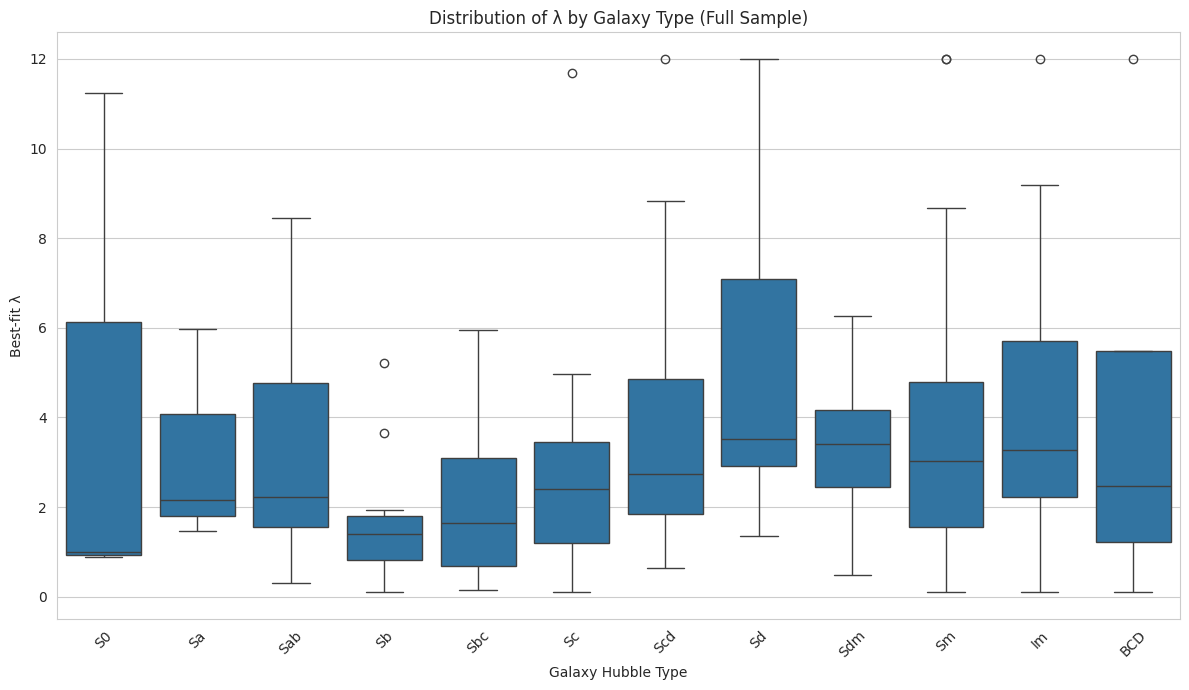

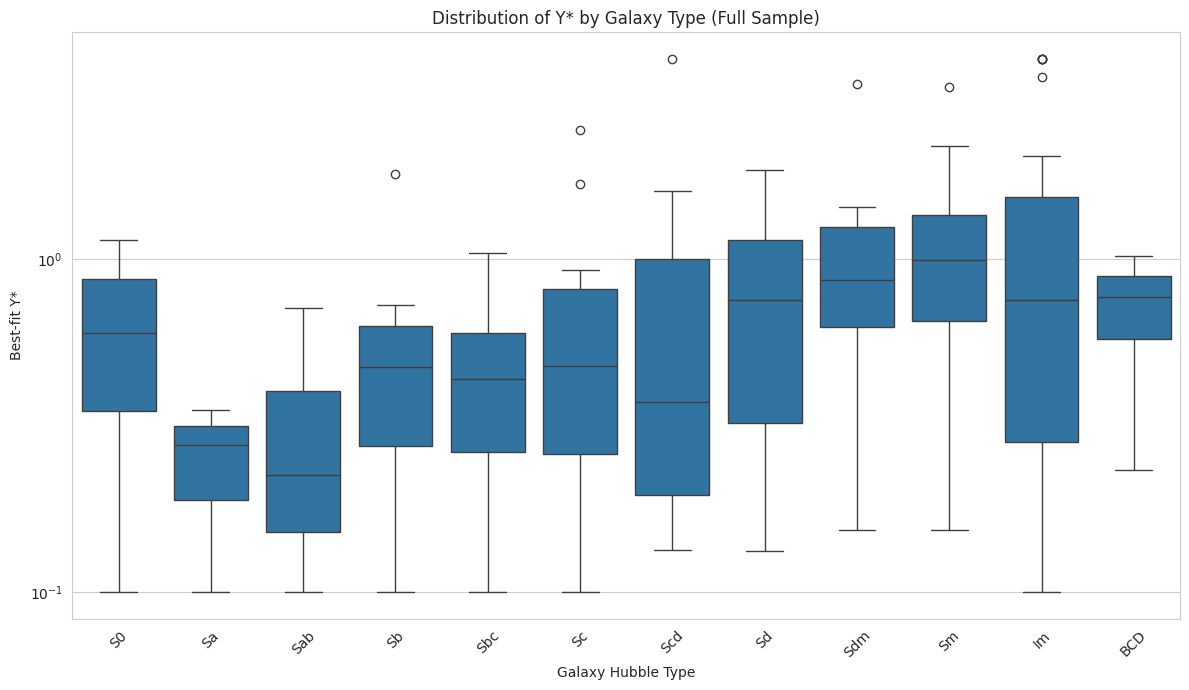


--- Analyzing 'Gold Standard' sample (164 galaxies with NRMSE < 15.0%) ---


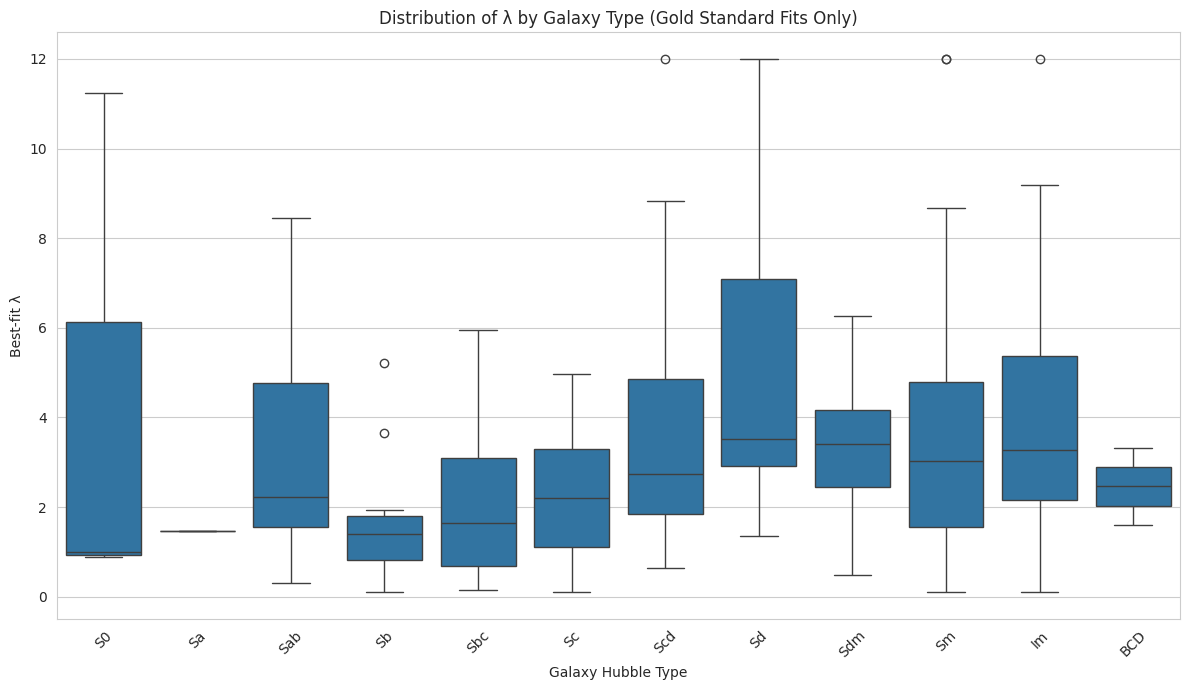

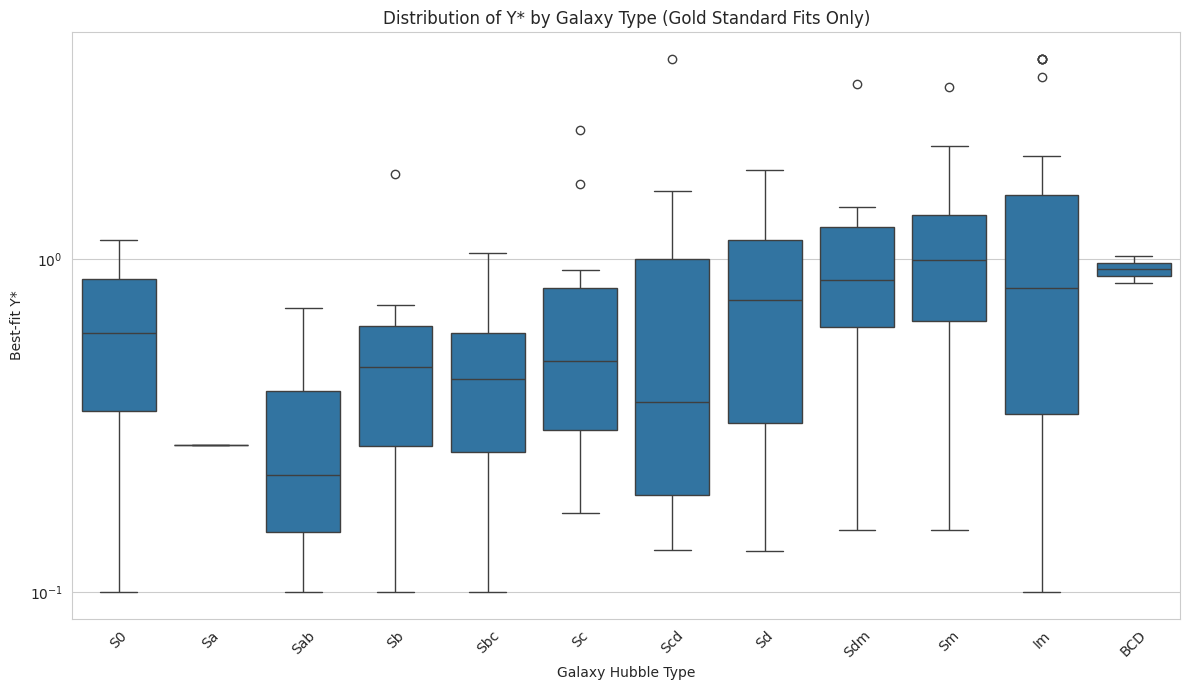

In [10]:
# =============================================================================
# WILL Framework: Morphological Analysis Script
#
# Purpose:
# 1. Finds the best-fit parameters (lambda, Y_star) for each SPARC galaxy.
# 2. Creates box plots to visualize the distribution of these parameters
#    across different galaxy morphological types (Hubble Types).
# 3. Repeats the analysis for a "gold standard" subset of the best-fitting
#    galaxies to identify clearer trends.
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import differential_evolution
from IPython.display import display
import warnings

# --- 0. Setup ---
warnings.filterwarnings("ignore")
# Set a consistent style for plots
sns.set_style("whitegrid")


# --- 1. Data Loading and Preparation ---
print("--- 1. Loading and Preparing Data ---")
DATA_PATH = '/content/DATA'
META_FILE = f'{DATA_PATH}/table1.dat'
CURVE_FILE = f'{DATA_PATH}/table2.dat'

try:
    props = pd.read_fwf(
        META_FILE,
        colspecs=[(0, 11), (12, 14)],
        names=['Name', 'Type'],
        header=None
    ).set_index('Name')
    print("Successfully loaded `table1.dat`.")

    curves = pd.read_table(
        CURVE_FILE, sep=r'\s+', comment='#', header=None,
        usecols=[0, 2, 3, 5, 6, 7],
        names=['Name', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbulge']
    )
    print("Successfully loaded `table2.dat`.")

    curves.fillna(0, inplace=True)
    curves.dropna(subset=['r', 'Vobs'], inplace=True)

except FileNotFoundError:
    print(f"\nERROR: Data files not found in '{DATA_PATH}'. Script cannot continue.")
    props = pd.DataFrame()
    curves = pd.DataFrame()


# --- 2. Core Model and Optimization Functions (Unchanged) ---
def will_v_integral(r, Vgas, Vdisk, Vbulge, y_star, lambda_val):
    v_bary_sq = Vgas**2 + y_star * (Vdisk**2 + Vbulge**2)
    integral = cumulative_trapezoid(v_bary_sq, r, initial=0.0)
    correction = np.zeros_like(r, dtype=float)
    non_zero_r = r > 1e-6
    correction[non_zero_r] = lambda_val * integral[non_zero_r] / r[non_zero_r]
    v_pred_sq = v_bary_sq + correction
    return np.sqrt(np.clip(v_pred_sq, 0, None))

def objective_function(params, df):
    y_star, lambda_val = params
    v_pred = will_v_integral(df['r'].values, df['Vgas'].values, df['Vdisk'].values,
                               df['Vbulge'].values, y_star, lambda_val)
    v_pred_clean = np.nan_to_num(v_pred, nan=0.0, posinf=0.0, neginf=0.0)
    return np.sqrt(np.mean((df['Vobs'].values - v_pred_clean)**2))

def fit_galaxy(df):
    bounds = [(0.1, 4.0), (0.1, 12.0)]
    result = differential_evolution(objective_function, bounds, args=(df,), tol=0.01, seed=42)
    return result.x[0], result.x[1], result.fun


# --- 3. Main Loop: Fit All Galaxies (Unchanged) ---
if not curves.empty:
    print("\n--- 2. Optimizing Parameters for Each Galaxy ---")
    print("This process may take several minutes...")

    fit_results = []
    galaxies_to_run = props[props.index.isin(curves['Name'].unique())].index

    for i, galaxy_name in enumerate(galaxies_to_run):
        gdf = curves[curves['Name'] == galaxy_name].sort_values('r')
        if len(gdf) < 5: continue

        y_star_best, lambda_best, rmse_best = fit_galaxy(gdf)
        mean_v_obs = gdf['Vobs'].mean()
        nrmse_best = rmse_best / mean_v_obs if mean_v_obs > 0 else np.inf

        fit_results.append({
            'Name': galaxy_name,
            'Y_star_best': y_star_best,
            'Lambda_best': lambda_best,
            'NRMSE_best': nrmse_best
        })

        if (i + 1) % 50 == 0:
            print(f"  ...processed {i+1}/{len(galaxies_to_run)} galaxies.")

    # --- 4. Merge Results and Prepare for Plotting ---
    print("\n--- 3. Merging Fit Results with Galaxy Properties ---")
    df_fits = pd.DataFrame(fit_results).set_index('Name')
    df_final = props.join(df_fits, how='inner')
    df_final.dropna(inplace=True)

    hubble_type_map = {
        0: 'S0', 1: 'Sa', 2: 'Sab', 3: 'Sb', 4: 'Sbc', 5: 'Sc',
        6: 'Scd', 7: 'Sd', 8: 'Sdm', 9: 'Sm', 10: 'Im', 11: 'BCD'
    }
    df_final['Hubble_Type'] = df_final['Type'].map(hubble_type_map)
    print("Successfully created final dataframe.")

    # --- 5. Generate Morphological Analysis Plots ---
    print("\n--- 4. Generating Morphological Analysis Plots ---")

    # Helper function for box plots
    def create_box_plot(data, y_col, y_label, title, y_log=False):
        plt.figure(figsize=(12, 7))
        sns.boxplot(x='Hubble_Type', y=y_col, data=data,
                    order=hubble_type_map.values())
        plt.xlabel("Galaxy Hubble Type")
        plt.ylabel(y_label)
        plt.title(title)
        if y_log:
            plt.yscale('log')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # --- Plots for the FULL sample ---
    create_box_plot(df_final, 'Lambda_best', 'Best-fit λ',
                    'Distribution of λ by Galaxy Type (Full Sample)')

    create_box_plot(df_final, 'Y_star_best', 'Best-fit Y*',
                    'Distribution of Y* by Galaxy Type (Full Sample)', y_log=True)

    # --- Filter for "Gold Standard" fits and re-plot ---
    NRMSE_THRESHOLD = 0.15 # Using galaxies with <15% relative error
    df_gold = df_final[df_final['NRMSE_best'] < NRMSE_THRESHOLD].copy()
    print(f"\n--- Analyzing 'Gold Standard' sample ({len(df_gold)} galaxies with NRMSE < {NRMSE_THRESHOLD*100}%) ---")

    create_box_plot(df_gold, 'Lambda_best', 'Best-fit λ',
                    'Distribution of λ by Galaxy Type (Gold Standard Fits Only)')

    create_box_plot(df_gold, 'Y_star_best', 'Best-fit Y*',
                    'Distribution of Y* by Galaxy Type (Gold Standard Fits Only)', y_log=True)

else:
    print("Script terminated because data files were not found.")

--- 1. Loading and Preparing Data ---
Successfully loaded `table1.dat`.
Successfully loaded `table2.dat`.

--- 2. Finding Best Harmonic Ratio for Each Galaxy ---

--- 3. Aggregating Results ---
Successfully created final dataframe with 171 galaxies.

--- Summary Statistics for the Harmonic Ratio Model ---
Median Absolute RMSE: 13.94 km/s
Median Normalized RMSE (NRMSE): 0.162 (or 16.2%)

--- 4. Generating Visualization ---


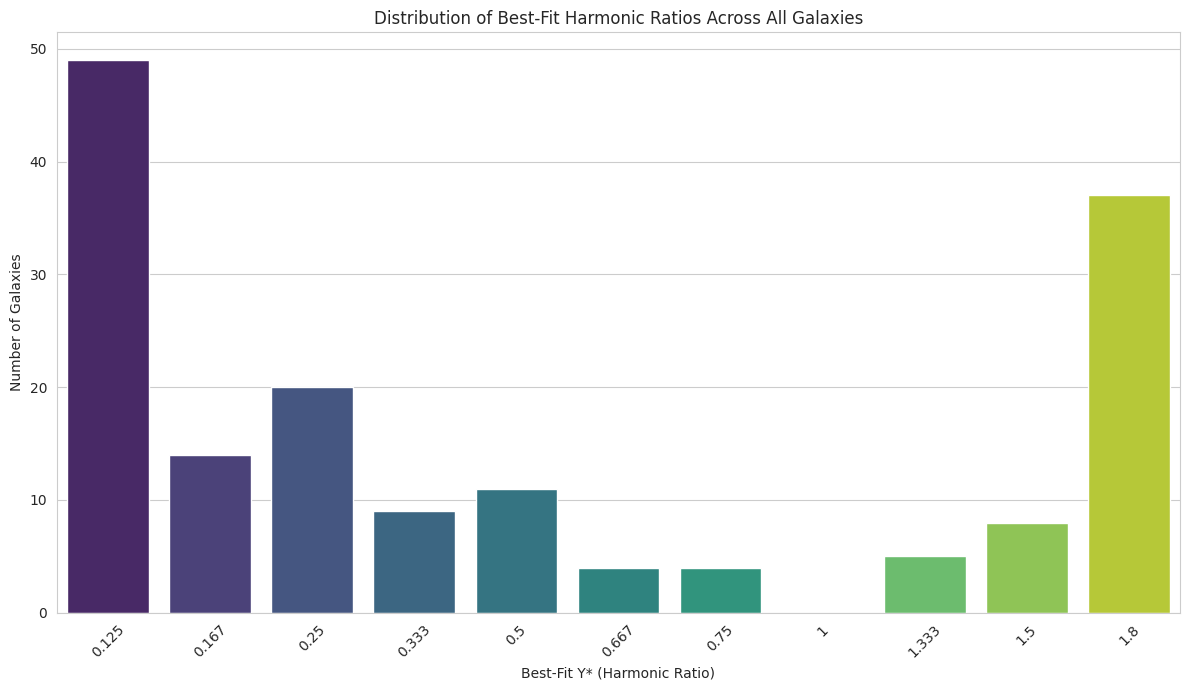

In [11]:
# =============================================================================
# WILL Framework: Harmonic Ratio Test
#
# Purpose:
# 1. Tests the hypothesis that Y_star and Lambda are linked by Y* = 1/L.
# 2. Restricts the possible values for Y* to a discrete set of
#    "beautiful fractions" to perform a highly constrained test of the model.
# 3. Calculates the best-fit fraction for each galaxy and visualizes
#    the overall preference.
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
from IPython.display import display
import warnings

# --- 0. Setup ---
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")


# --- 1. Data Loading and Preparation ---
print("--- 1. Loading and Preparing Data ---")
DATA_PATH = '/content/DATA'
META_FILE = f'{DATA_PATH}/table1.dat'
CURVE_FILE = f'{DATA_PATH}/table2.dat'

try:
    props = pd.read_fwf(
        META_FILE, colspecs=[(0, 11)], names=['Name'], header=None
    ).set_index('Name')
    print("Successfully loaded `table1.dat`.")
    curves = pd.read_table(
        CURVE_FILE, sep=r'\s+', comment='#', header=None,
        usecols=[0, 2, 3, 5, 6, 7],
        names=['Name', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbulge']
    )
    print("Successfully loaded `table2.dat`.")
    curves.fillna(0, inplace=True)
    curves.dropna(subset=['r', 'Vobs'], inplace=True)
except FileNotFoundError:
    print(f"\nERROR: Data files not found in '{DATA_PATH}'. Script cannot continue.")
    props = pd.DataFrame()
    curves = pd.DataFrame()


# --- 2. Core Model and Grid Search Functions ---

# The list of "beautiful fractions" for Y_star
HARMONIC_RATIOS = [1/8, 1/6, 1/4, 1/3, 1/2, 1, 6/4, 9/5, 2/3, 3/2, 4/3, 3/4]
# For cleaner plotting, we can create string labels for them
RATIO_LABELS = ['1/8','1/6','1/4','1/3','1/2','1','3/2','9/5','2/3','3/2','4/3','3/4']


def will_v_integral(r, Vgas, Vdisk, Vbulge, y_star, lambda_val):
    """Calculates rotation velocity using the WILL integral formula."""
    v_bary_sq = Vgas**2 + y_star * (Vdisk**2 + Vbulge**2)
    integral = cumulative_trapezoid(v_bary_sq, r, initial=0.0)
    correction = np.zeros_like(r, dtype=float)
    non_zero_r = r > 1e-6
    correction[non_zero_r] = lambda_val * integral[non_zero_r] / r[non_zero_r]
    v_pred_sq = v_bary_sq + correction
    return np.sqrt(np.clip(v_pred_sq, 0, None))

def find_best_fraction(df, ratios):
    """
    Iterates through the discrete list of harmonic ratios to find the best fit.
    This replaces the continuous optimizer.
    """
    best_rmse = np.inf
    best_y_star = None

    for y_star_candidate in ratios:
        lambda_candidate = 1 / y_star_candidate

        v_pred = will_v_integral(df['r'].values, df['Vgas'].values, df['Vdisk'].values,
                                   df['Vbulge'].values, y_star_candidate, lambda_candidate)

        v_pred_clean = np.nan_to_num(v_pred, nan=0.0, posinf=0.0, neginf=0.0)
        current_rmse = np.sqrt(np.mean((df['Vobs'].values - v_pred_clean)**2))

        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_y_star = y_star_candidate

    return best_y_star, (1 / best_y_star), best_rmse


# --- 3. Main Loop: Test Ratios for All Galaxies ---
if not curves.empty:
    print("\n--- 2. Finding Best Harmonic Ratio for Each Galaxy ---")

    fit_results = []
    galaxies_to_run = props[props.index.isin(curves['Name'].unique())].index

    for i, galaxy_name in enumerate(galaxies_to_run):
        gdf = curves[curves['Name'] == galaxy_name].sort_values('r')
        if len(gdf) < 5: continue

        y_star_best, lambda_best, rmse_best = find_best_fraction(gdf, HARMONIC_RATIOS)

        mean_v_obs = gdf['Vobs'].mean()
        nrmse_best = rmse_best / mean_v_obs if mean_v_obs > 0 else np.inf

        fit_results.append({
            'Name': galaxy_name,
            'Best_Y_star': y_star_best,
            'Best_Lambda': lambda_best,
            'RMSE_best': rmse_best,
            'NRMSE_best': nrmse_best
        })

    # --- 4. Final DataFrame and Summary ---
    print("\n--- 3. Aggregating Results ---")
    df_final = pd.DataFrame(fit_results).set_index('Name')
    df_final.dropna(inplace=True)
    print(f"Successfully created final dataframe with {len(df_final)} galaxies.")

    print("\n--- Summary Statistics for the Harmonic Ratio Model ---")
    print(f"Median Absolute RMSE: {df_final['RMSE_best'].median():.2f} km/s")
    print(f"Median Normalized RMSE (NRMSE): {df_final['NRMSE_best'].median():.3f} (or {df_final['NRMSE_best'].median()*100:.1f}%)")

    # --- 5. Generate Plots ---
    print("\n--- 4. Generating Visualization ---")

    # Create a column with string representation for better plotting
    df_final['Best_Y_star_str'] = df_final['Best_Y_star'].round(3).astype(str)

    plt.figure(figsize=(12, 7))
    sns.countplot(x='Best_Y_star_str', data=df_final,
                  order=[str(round(r, 3)) for r in sorted(list(set(HARMONIC_RATIOS)))],
                  palette='viridis')
    plt.xlabel("Best-Fit Y* (Harmonic Ratio)")
    plt.ylabel("Number of Galaxies")
    plt.title("Distribution of Best-Fit Harmonic Ratios Across All Galaxies")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("Script terminated because data files were not found.")

--- 1. Loading and Preparing Data ---
Successfully loaded `table1.dat`.
Successfully loaded `table2.dat`.

--- 2. Finding Best Harmonic Ratio for Each Galaxy ---

--- 3. Merging Data and Preparing for Analysis ---
Successfully created final dataframe.

--- 4. Generating Visualizations ---


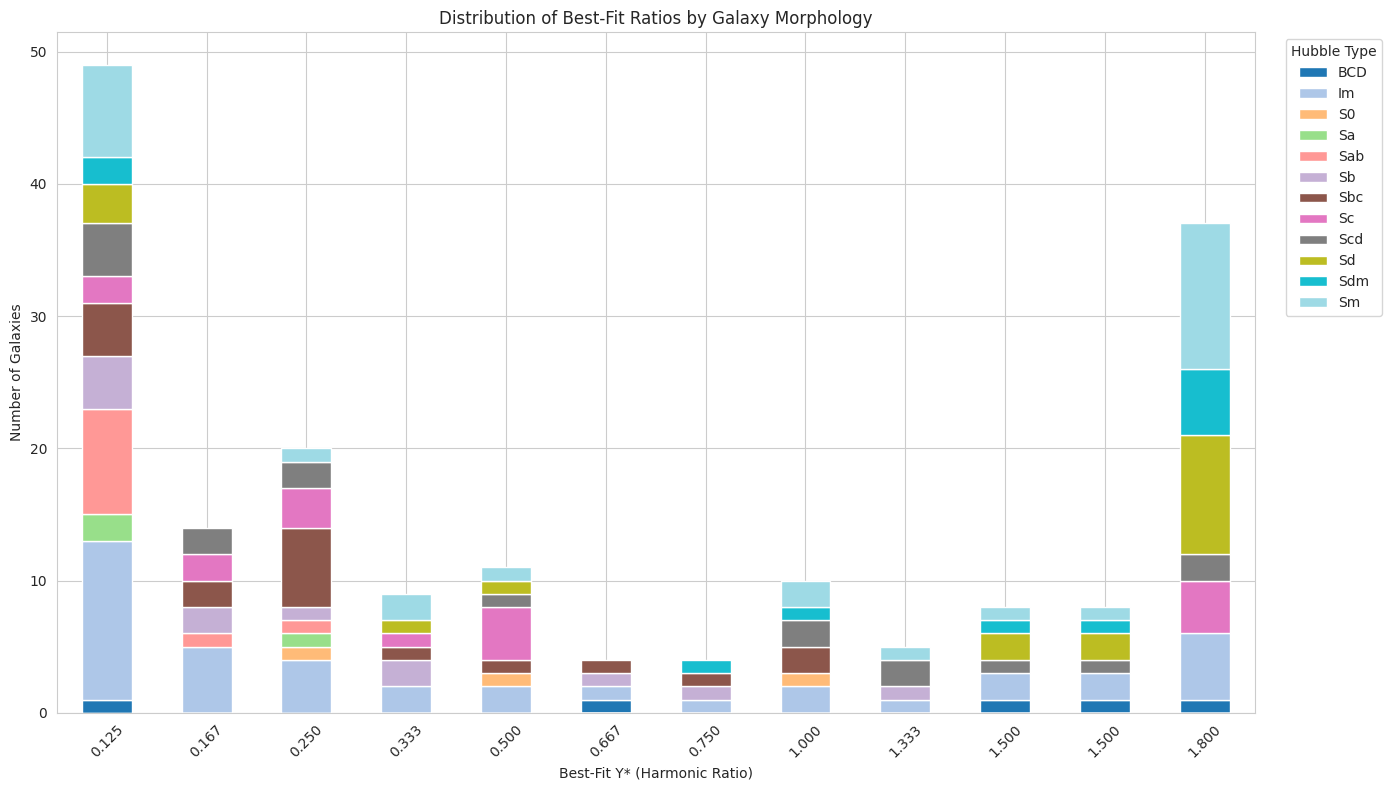

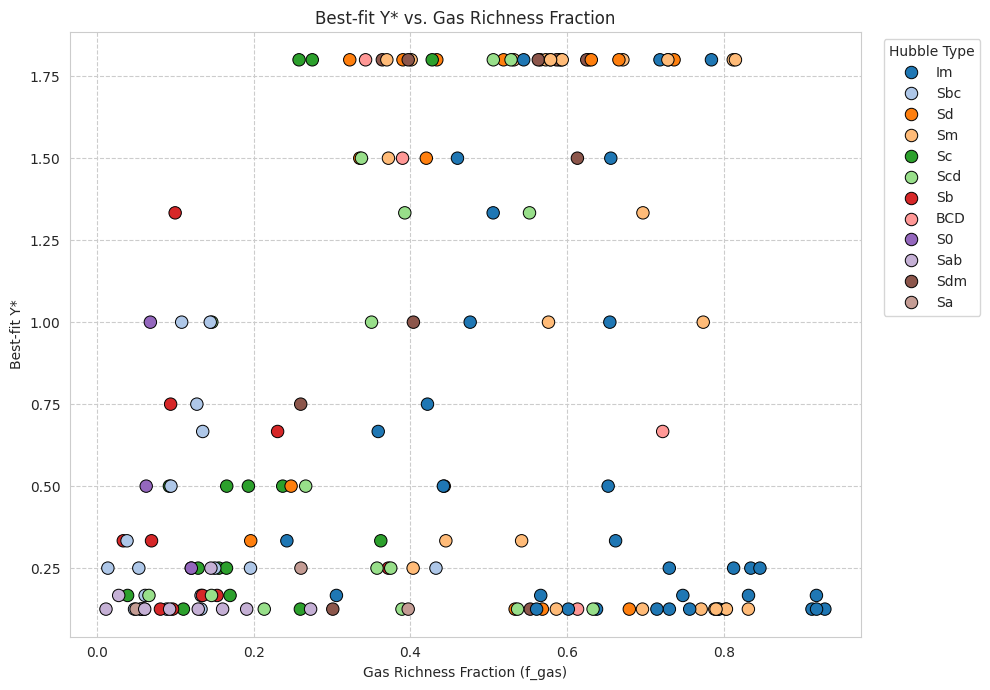

In [12]:
# =============================================================================
# WILL Framework: Final Analysis Script
#
# Purpose:
# 1. Finds the best-fit harmonic ratio (Y* and L=1/Y*) for each galaxy.
# 2. Creates a stacked bar chart to show the morphological distribution
#    of galaxies for each preferred ratio.
# 3. Creates a scatter plot to test the relationship between a galaxy's
#    gas richness and the certainty of the best-fit Y*.
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
from IPython.display import display
import warnings

# --- 0. Setup ---
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")


# --- 1. Data Loading and Preparation ---
print("--- 1. Loading and Preparing Data ---")
DATA_PATH = '/content/DATA'
META_FILE = f'{DATA_PATH}/table1.dat'
CURVE_FILE = f'{DATA_PATH}/table2.dat'

try:
    # Load all necessary columns from table1.dat
    props = pd.read_fwf(
        META_FILE,
        colspecs=[(0, 11), (12, 14), (40, 47), (86, 93)],
        names=['Name', 'Type', 'L3.6', 'MHI'],
        header=None
    ).set_index('Name')
    print("Successfully loaded `table1.dat`.")

    curves = pd.read_table(
        CURVE_FILE, sep=r'\s+', comment='#', header=None,
        usecols=[0, 2, 3, 5, 6, 7],
        names=['Name', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbulge']
    )
    print("Successfully loaded `table2.dat`.")
    curves.fillna(0, inplace=True)
    curves.dropna(subset=['r', 'Vobs'], inplace=True)
except FileNotFoundError:
    print(f"\nERROR: Data files not found in '{DATA_PATH}'. Script cannot continue.")
    props = pd.DataFrame()
    curves = pd.DataFrame()


# --- 2. Core Model and Grid Search Functions (Unchanged) ---
HARMONIC_RATIOS = sorted([1/8, 1/6, 1/4, 1/3, 1/2, 1, 6/4, 9/5, 2/3, 3/2, 4/3, 3/4])

def will_v_integral(r, Vgas, Vdisk, Vbulge, y_star, lambda_val):
    v_bary_sq = Vgas**2 + y_star * (Vdisk**2 + Vbulge**2)
    integral = cumulative_trapezoid(v_bary_sq, r, initial=0.0)
    correction = np.zeros_like(r, dtype=float)
    non_zero_r = r > 1e-6
    correction[non_zero_r] = lambda_val * integral[non_zero_r] / r[non_zero_r]
    v_pred_sq = v_bary_sq + correction
    return np.sqrt(np.clip(v_pred_sq, 0, None))

def find_best_fraction(df, ratios):
    best_rmse = np.inf
    best_y_star = None
    for y_star_candidate in ratios:
        lambda_candidate = 1 / y_star_candidate
        v_pred = will_v_integral(df['r'].values, df['Vgas'].values, df['Vdisk'].values,
                                   df['Vbulge'].values, y_star_candidate, lambda_candidate)
        v_pred_clean = np.nan_to_num(v_pred, nan=0.0, posinf=0.0, neginf=0.0)
        current_rmse = np.sqrt(np.mean((df['Vobs'].values - v_pred_clean)**2))
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_y_star = y_star_candidate
    return best_y_star, (1 / best_y_star), best_rmse


# --- 3. Main Loop: Find Best Ratios for All Galaxies ---
if not curves.empty:
    print("\n--- 2. Finding Best Harmonic Ratio for Each Galaxy ---")
    fit_results = []
    galaxies_to_run = props[props.index.isin(curves['Name'].unique())].index

    for i, galaxy_name in enumerate(galaxies_to_run):
        gdf = curves[curves['Name'] == galaxy_name].sort_values('r')
        if len(gdf) < 5: continue
        y_star_best, lambda_best, rmse_best = find_best_fraction(gdf, HARMONIC_RATIOS)
        fit_results.append({'Name': galaxy_name, 'Best_Y_star': y_star_best})

    # --- 4. Merge Data and Calculate New Metrics ---
    print("\n--- 3. Merging Data and Preparing for Analysis ---")
    df_fits = pd.DataFrame(fit_results).set_index('Name')
    df_final = props.join(df_fits, how='inner')

    # Add human-readable Hubble Type
    hubble_type_map = {0:'S0', 1:'Sa', 2:'Sab', 3:'Sb', 4:'Sbc', 5:'Sc',
                       6:'Scd', 7:'Sd', 8:'Sdm', 9:'Sm', 10:'Im', 11:'BCD'}
    df_final['Hubble_Type'] = df_final['Type'].map(hubble_type_map)

    # Calculate Gas Richness Fraction
    # Assuming a baseline Y_star=0.5 to estimate stellar mass from luminosity
    stellar_mass_proxy = df_final['L3.6'] * 0.5
    df_final['Gas_Fraction'] = df_final['MHI'] / (df_final['MHI'] + stellar_mass_proxy)
    df_final.dropna(inplace=True)
    print("Successfully created final dataframe.")

    # --- 5. Generate Final Plots ---
    print("\n--- 4. Generating Visualizations ---")

    # Plot 1: Stacked Bar Chart for Morphology
    # Prepare data for stacked bar chart
    ratio_counts = df_final.groupby(['Best_Y_star', 'Hubble_Type']).size().unstack(fill_value=0)
    ratio_counts = ratio_counts.loc[[r for r in HARMONIC_RATIOS if r in ratio_counts.index]]

    # Use a color palette for galaxy types
    type_colors = plt.cm.get_cmap('tab20', len(hubble_type_map))

    fig, ax = plt.subplots(figsize=(14, 8))
    ratio_counts.plot(kind='bar', stacked=True, ax=ax, colormap=type_colors)

    ax.set_title('Distribution of Best-Fit Ratios by Galaxy Morphology')
    ax.set_xlabel('Best-Fit Y* (Harmonic Ratio)')
    ax.set_ylabel('Number of Galaxies')
    ax.set_xticklabels([f'{r:.3f}' for r in ratio_counts.index], rotation=45)
    ax.legend(title='Hubble Type', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot 2: Scatter Plot for Gas Richness
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_final, x='Gas_Fraction', y='Best_Y_star', hue='Hubble_Type',
                    palette='tab20', s=80, edgecolor='black')
    plt.title('Best-fit Y* vs. Gas Richness Fraction')
    plt.xlabel('Gas Richness Fraction (f_gas)')
    plt.ylabel('Best-fit Y*')
    plt.legend(title='Hubble Type', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

else:
    print("Script terminated because data files were not found.")

--- 1. Loading and Preparing Data ---
Successfully loaded `table2.dat`.

--- 2. Generating Plots for Specific Galaxies ---

Processing UGC07323 with Y*=0.83, Lambda=1.2...


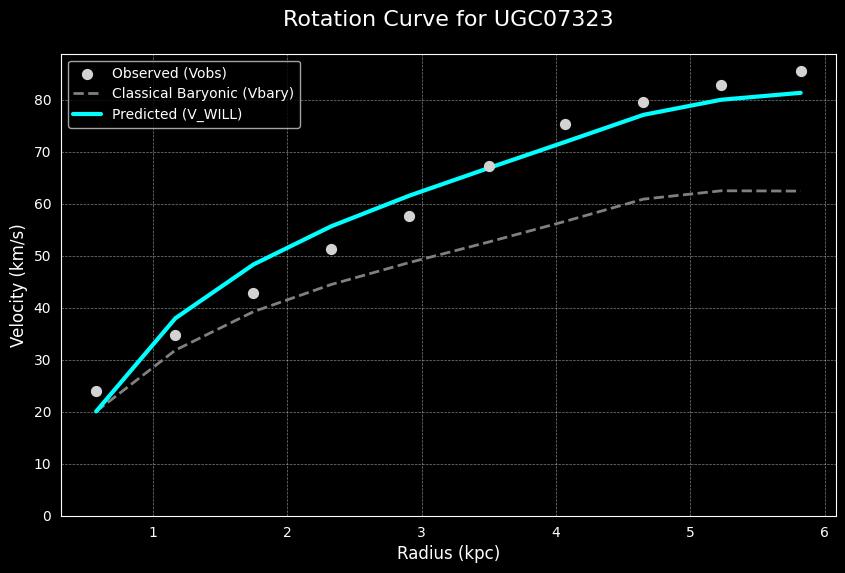


Processing UGC07524 with Y*=0.85, Lambda=4.04...


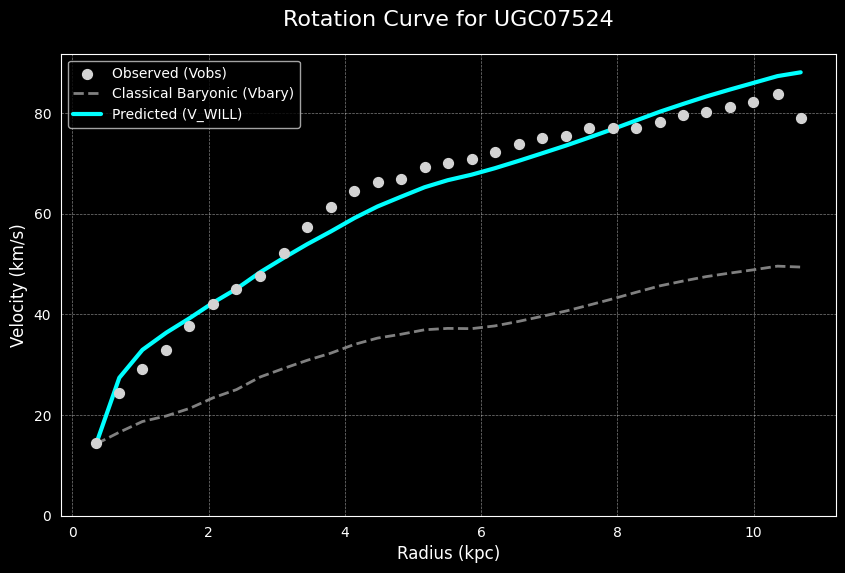


Processing DDO161 with Y*=0.1, Lambda=4.25...


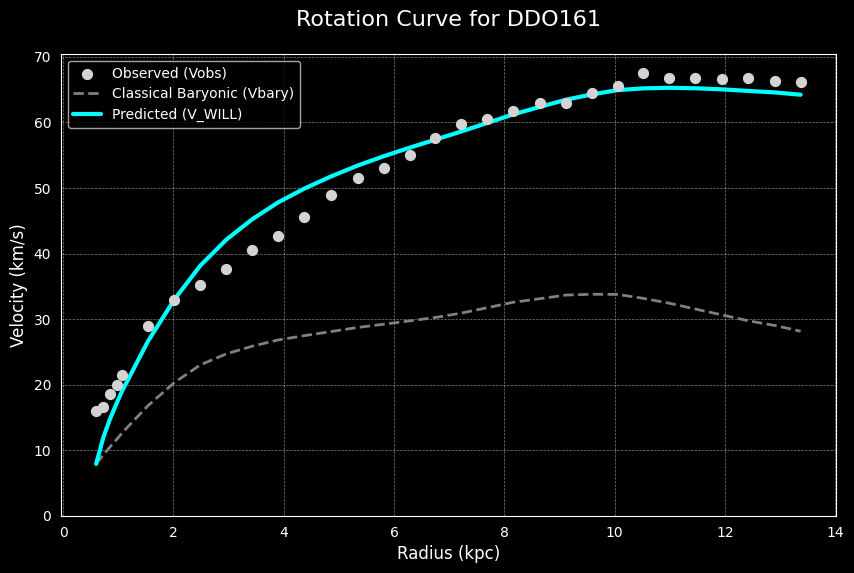


Processing NGC6503 with Y*=0.25, Lambda=4.0...


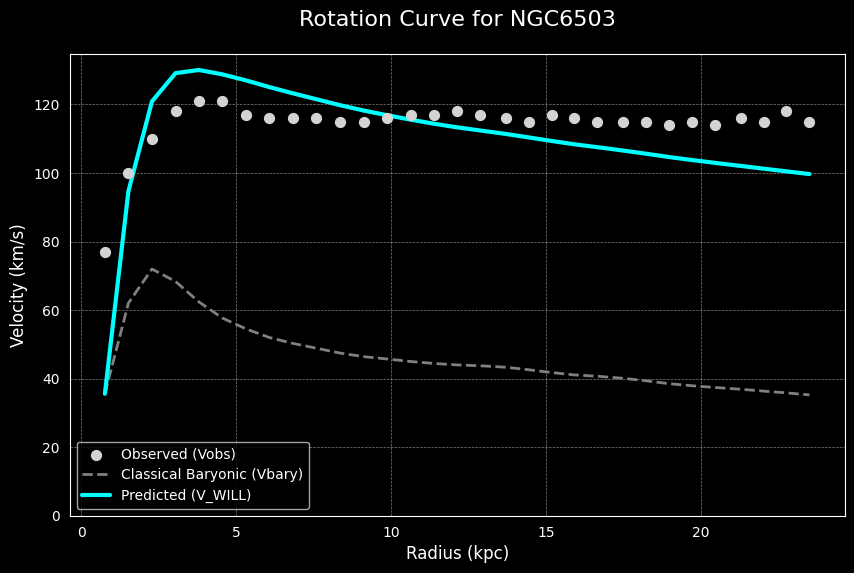


Processing NGC4088 with Y*=0.25, Lambda=1.5...


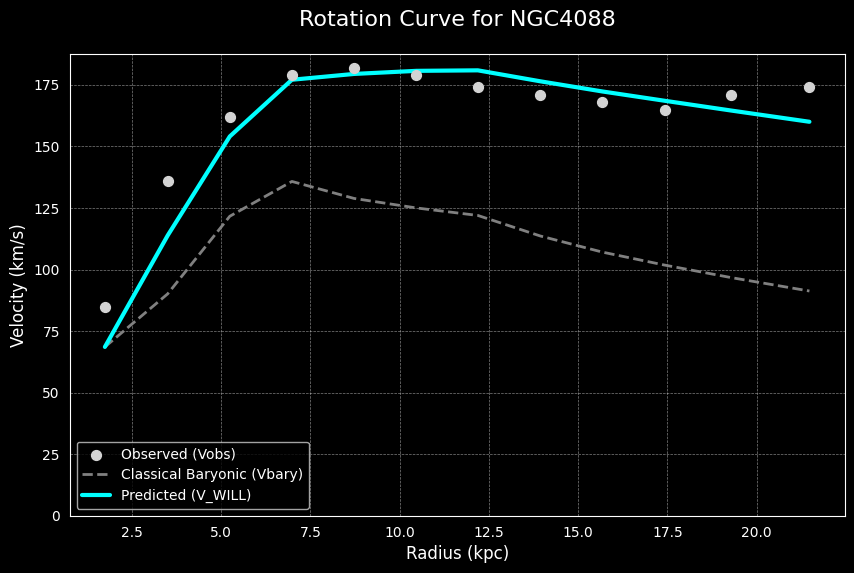

In [13]:
# =============================================================================
# WILL Framework: Specific Galaxy Plotting Script
#
# Purpose:
# 1. Loads the data for five specific galaxies.
# 2. For each galaxy, applies a predefined set of parameters (Y_star, Lambda).
# 3. Calculates the predicted rotation curve using the integral model.
# 4. Generates a plot for each galaxy matching the user-provided style.
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from IPython.display import display
import warnings

# --- 0. Setup ---
warnings.filterwarnings("ignore")
# Use a dark background style to match the example plots
plt.style.use('dark_background')

# --- 1. Data Loading ---
print("--- 1. Loading and Preparing Data ---")
DATA_PATH = '/content/DATA'
CURVE_FILE = f'{DATA_PATH}/table2.dat'

try:
    curves = pd.read_table(
        CURVE_FILE, sep=r'\s+', comment='#', header=None,
        usecols=[0, 2, 3, 5, 6, 7],
        names=['Name', 'r', 'Vobs', 'Vgas', 'Vdisk', 'Vbulge']
    )
    print("Successfully loaded `table2.dat`.")
    curves.fillna(0, inplace=True)
    curves.dropna(subset=['r', 'Vobs'], inplace=True)
except FileNotFoundError:
    print(f"\nERROR: Data file not found in '{DATA_PATH}'. Script cannot continue.")
    curves = pd.DataFrame()

# --- 2. Core Model and Plotting Functions ---
def will_v_integral(r, Vgas, Vdisk, Vbulge, y_star, lambda_val):
    """Calculates rotation velocity using the WILL integral formula."""
    v_bary_sq = Vgas**2 + y_star * (Vdisk**2 + Vbulge**2)
    integral = cumulative_trapezoid(v_bary_sq, r, initial=0.0)
    correction = np.zeros_like(r, dtype=float)
    non_zero_r = r > 1e-6
    correction[non_zero_r] = lambda_val * integral[non_zero_r] / r[non_zero_r]
    v_pred_sq = v_bary_sq + correction
    return np.sqrt(np.clip(v_pred_sq, 0, None))

def plot_rotation_curve(df, galaxy_name, params):
    """Generates a styled plot for a single galaxy."""
    y_star, lambda_val = params

    # Calculate the two velocity curves
    v_bary = np.sqrt(df['Vgas']**2 + y_star * (df['Vdisk']**2 + df['Vbulge']**2))
    v_will = will_v_integral(df['r'].values, df['Vgas'].values, df['Vdisk'].values,
                               df['Vbulge'].values, y_star, lambda_val)

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot data points and curves
    plt.scatter(df['r'], df['Vobs'], color='lightgray', s=50, label='Observed (Vobs)', zorder=5)
    plt.plot(df['r'], v_bary, color='gray', linestyle='--', linewidth=2, label='Classical Baryonic (Vbary)')
    plt.plot(df['r'], v_will, color='cyan', linewidth=3, label='Predicted (V_WILL)')

    # Styling
    plt.title(f"Rotation Curve for {galaxy_name}", fontsize=16, pad=20)
    plt.xlabel("Radius (kpc)", fontsize=12)
    plt.ylabel("Velocity (km/s)", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.ylim(bottom=0) # Ensure y-axis starts at 0

    plt.show()


# --- 3. Main Execution Block ---
if not curves.empty:
    print("\n--- 2. Generating Plots for Specific Galaxies ---")

    # Define the list of galaxies and their fixed parameters
    galaxy_params = {
        'UGC07323': (0.83, 1.2),  # (Y_star, Lambda)
        'UGC07524': (0.85, 4.04),
        'DDO161':   (0.1, 4.25),
        'NGC6503':  (0.25, 4.0),
        'NGC4088':  (0.25, 1.5)
    }

    for name, params in galaxy_params.items():
        print(f"\nProcessing {name} with Y*={params[0]}, Lambda={params[1]}...")
        galaxy_df = curves[curves['Name'] == name].sort_values('r')

        if galaxy_df.empty:
            print(f"  > WARNING: Could not find data for galaxy {name}.")
            continue

        plot_rotation_curve(galaxy_df, name, params)
else:
    print("Script terminated because data files were not found.")